# **Описание проекта**

Вы — специалист по Data Sciense в каршеринговой компании. Вам поступил заказ: нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.
Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.


Идея решения задачи от заказчика: 
1. Создать модель предсказания ДТП (целевое значение — **at_fault (виновник)** в таблице **parties**)
    - Для модели выбрать тип виновника — только машина (**car**).
    - Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
    - Для моделирования ограничиться данными за `2012` год — они самые свежие.
    - Обязательное условие — учесть фактор возраста автомобиля.
2. На основе модели исследовать основные факторы ДТП.
3. Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
    - Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
    - Какие ещё факторы нужно учесть?
    - Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

Заказчик предлагает вам поработать с базой данных по происшествиям и сформировать свои идеи создания такой системы. 

# Шаг 1. Загрузите таблицы sql

Подключитесь к базе данных, используя данные.

```
db_config = {
'user': '...', # имя пользователя,
'pwd': '...', # пароль,
'host': '...',
'port': ..., # порт подключения,
'db': '...' # название базы данных,
} 
```

Устанавливаем нужные пакеты/убеждаемся, что они доступны.

In [264]:
%pip install psycopg2-binary category_encoders==2.6.0 lightgbm catboost

Note: you may need to restart the kernel to use updated packages.


Подключаем необходимые модули:

In [265]:
import psycopg2
import sqlalchemy
from sqlalchemy.sql import text

import pandas as pd
import pandas.io.sql as sqlio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, PrecisionRecallDisplay

from category_encoders import TargetEncoder

import lightgbm as lgb
from catboost import CatBoostClassifier

Подключаемся к базе данных и узнаем, какие таблицы в ней есть:

In [266]:
url = '...'
engine = sqlalchemy.create_engine(url)

sql = """
    SELECT table_name FROM information_schema.tables WHERE table_schema='public';
"""
conn = engine.connect()
query = conn.execute(text(sql))
TABLES = []
for table in query.fetchall():
    table_name = table[0]
    TABLES.append(table_name)
    print(table_name)

case_ids
collisions
parties
vehicles


Итак, в БД обнаружены следующие таблицы:

- **`case_ids`**;
- **`collisions`**;
- **`parties`**;
- **`vehicles`**.

# Шаг 2. Проведите первичное исследование таблиц

Для осмотра таблиц используйте sql-запрос.

In [267]:
for table_name in TABLES:
    print(table_name)
    sql_df = sqlio.read_sql_query(f"SELECT COUNT(*) FROM {table_name};", conn)
    display(sql_df)

case_ids


,count
0,1400000


collisions


,count
0,1400000


parties


,count
0,2752408


vehicles


,count
0,1021234


Видим, что записи есть во всех таблицах, и записей много. Посмотрим на _шапки_ каддой из таблиц:

In [268]:
for table_name in TABLES:
    print(table_name)
    sql_df = sqlio.read_sql_query(f"SELECT * FROM {table_name} LIMIT 5;", conn)
    display(sql_df)

case_ids


,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


collisions


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.00000,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.00000,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.00000,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.00000,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.00000,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


parties


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.00000,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.00000,had not been drinking,None,0
2,29,3899462,2,car,0,21.00000,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.00000,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


vehicles


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


### Шаг 2.1 Все ли таблицы имеют набор данных

Посмтрим нам таблицы подробнее.

- #### Таблица **`case_ids`**

Выясним, представляет ли данная таблица для нас какую-либо ценность. Для этого посмотрим все различные значения поля `db_year` в ней:

In [269]:
sql_df = sqlio.read_sql_query(f"SELECT DISTINCT case_ids.db_year FROM case_ids;", conn)
display(sql_df)

,db_year
0,2021


___________

Видим, что во втором столбце только `2021` год - таблица кажется бесполезной для нашей задачи.

- #### Таблица **`collisions`**

In [270]:
sql_df = sqlio.read_sql_query(f"SELECT * FROM collisions LIMIT 10;", conn)
display(sql_df)

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.00000,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.00000,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.00000,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.00000,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.00000,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
5,4083097,0109,alameda,0.00000,None,1,clear,ramp,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-18,02:18:00
6,4083092,1942,los angeles,1320.00000,south,0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
7,4083096,1942,los angeles,200.00000,south,0,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,08:55:00
8,4083100,1942,los angeles,2112.00000,north,0,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
9,4083103,4313,santa clara,0.00000,None,1,cloudy,None,scratch,2,vehicle code violation,None,broadside,other motor vehicle,wet,normal,dusk or dawn,functioning,2009-01-02,15:55:00


Видим, что поле `case_id` является первичным ключом, дублей по данному полю нет, поскольку каждое значение описывает некоторое одно ДТП. Стороны ДТП же рассматриваются в других таблицах, связь с ними осуществляется как раз с помощью поля `case_id`. Данная таблица, безусловно, имеет набор данных.

_____________

- #### Таблица **`parties`**

In [271]:
sql_df = sqlio.read_sql_query(f"SELECT * FROM parties LIMIT 10;", conn)
display(sql_df)

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.00000,had not been drinking,None,0.00000
1,23,3899454,2,road signs,0,7.00000,had not been drinking,None,0.00000
2,29,3899462,2,car,0,21.00000,had not been drinking,None,0.00000
3,31,3899465,2,road signs,0,24.00000,had not been drinking,None,0.00000
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.00000
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.00000
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.00000
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.00000
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.00000
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN


Первые же две строки таблицы показывают, как два участника одного и того же ДТП с `case_id` `3899454` описываются двумя записями этой таблицы, для каждого из участников проставлены соответствующие `party_number` равные `1` и `2`. Отметим также `None` и `NaN` в полях, которые, судя по всему, представляют собой пропуски. Данная таблица также содержит набор данных.

_____________

- #### Таблица **`vehicles`**

In [272]:
sql_df = sqlio.read_sql_query(f"SELECT * FROM vehicles LIMIT 10;", conn)
display(sql_df)

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9
7,1175715,5305033,1,sedan,manual,10
8,1175716,5305033,2,sedan,manual,4
9,1175758,5305060,2,sedan,auto,11


Автомобили-участники ДТП задаются своими идентификаторами (`id`), а также перой `case_id` + `party_number`, с помощью которых можно выйти на данные о ДТП, где данный автомобиль поучаствовал. И эта таблица вне всяких сомнений имеет нужный для нас набор данных.

___________

### Шаг 2.2 Соответствует ли количество таблиц условию задачи

Отбросив ненужную нам таблицу `case_ids`, мы остаёмся с таблицами 3 таблицами: `collisions`, `parties` и `vehicles`.

Их нам будет достаточно для нашей задачи:

- первая из них, `collisions`, предоставляет нам множество информации о ДТП, включая локацию, направление движения, погоду, степень повреждений участников;

- вторая, `parties`, позволяет узнать, что за физическая сущность была участником ДТП (автомобиль, дорожный знак и проч.), был ли данный участник виновником проишествия;

- последняя, `vehicles`, содержит данные об автомобилях, и хотя нам не будут известны марка и модель, мы узнаем о типе кузова и трансмиссии, а также о возрасте авто в годах.

_________

### Шаг 2.3 Имеется ли общий ключ для связи таблиц

Связь между таблицами можно описать следующим образом:

- изначально у нас есть идентификатор ДТП из таблицы `COLLISIONS` - это `case_id`, который задаёт случившееся ДТП. Поле `party_count` также сообщит нам о количестве сторон в данном ДТП;

- зная `case_id`, мы можем обратиться к таблице `PARTIES` по соответствующему полю в ней, чтобы получить больше информации о каждой из сторо ДТП. Каждая из сторон ДТП будет задаваться парой `case-id` + `part_number`, находящихся в одной записи (строке) данной таблицы;

- наконец, зная `case_id` + `party_number`, мы можем обратиться к таблице `VEHICLES`, чтобы получить больше информации о стороне-участнице ДТП, <u>которая является автомобилем</u>.

Таким образом данные всех 3 наших таблиц связаны между собой и могут быть обработаны посредством запросов языка SQL.

______________

# Шаг 3. Проведите статистический анализ факторов ДТП

#### Шаг 3.1 Выясните, в какие месяцы происходит наибольшее количество аварий. Проанализируйте весь период наблюдений (таблица collisions). Создайте sql-запрос

In [273]:
sql_df = sqlio.read_sql_query(
f"""
    SELECT TO_CHAR(collisions.collision_date, 'Month') AS month,
           EXTRACT(MONTH FROM collisions.collision_date) AS month_index,
           COUNT(collisions.case_id)
    FROM collisions
    GROUP BY month, month_index
    ORDER BY month_index;
""", conn)
sql_df.drop('month_index', axis=1, inplace=True) # уничтожим столбец month_index - он был нужен только для сортировки
display(sql_df)

,month,count
0,January,132044
1,February,128858
2,March,139581
3,April,130180
4,May,130316
5,June,102594
6,July,102227
7,August,104089
8,September,105159
9,October,112237


#### Постройте график



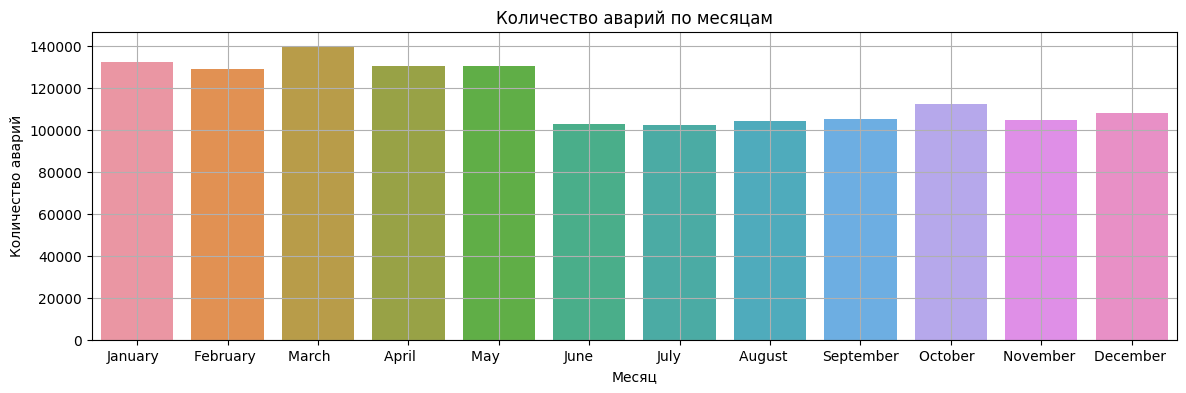

In [274]:
fig, ax = plt.subplots(figsize=(14, 4))
_ = sns.barplot(data=sql_df, x='month', y='count', ax=ax)
_ = ax.set_title('Количество аварий по месяцам')
_ = ax.set_xlabel('Месяц')
_ = ax.set_ylabel('Количество аварий')
_ = ax.grid(True)

#### Сделайте вывод

Из стобчатой диаграммы видно, что большинство аварий приходится на первые месяцы года - с января по май.

Версия о влиянии зимнего времени года, скорее всего, несостоятельна, поскольку наблюдается высокое количество аварий в мае (что странно) и низкое (не увеличенное) - в декабре (что также странно). Говорить о том, что по второй половине года произошли какие-то изменения в ПДД, снизившие количество ДТП, также нельзя, поскольку таблица `collisions` содержит данные об авариях за несколько лет.

_____________

#### Шаг 3.2 Скоро состоится первое совещание вашей рабочей группы. Чтобы обсуждение было конструктивным, каждый сотрудник должен понимать данные. Для этого вы должны создать подходящие аналитические задачи и поручить их решение коллегам.

Примеры задач:

- Проведите анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (связать **collisions** и **parties**);
- Найдите самые частые причины ДТП (таблица **parties**).

Создайте не менее шести задач для коллег. Опирайтесь на примеры и таблицы.

Создаём задачи:

- <b>Задача 1.</b> Узнать, сколько на каждый тип кузова автомобиля приходится водителей, находящихся под действием каких-либо веществ: алкоголя или лекарств/таблеток (таблицы **vehicles** и **parties**).

- <b>Задача 2.</b> Узнать о влиянии использования телефона на _виновность_ в ДТП: вычислить процент использовавших мобильный телефон водителей среди всех виновников ДТП (таблица **parties**).

- <b>Задача 3.</b> Провести анализ возрастов автомобилей-виновников ДТП, разделив все возраста на подходящие группы по несколько лет (талбицы **vehicles** и **parties**).

- <b>Задача 4.</b> Среди всех ДТП с одним участником высянить распределение размеров страховой премии (таблицы **collisions** и **parties**).

- <b>Задача 5.</b> Выяснить наиболее частотные локации всех ДТП, в которых обеими сторонами являются автомобили (таблицы **collisions** и **parties**).

- <b>Задача 6.</b> Посмотреть на распределение среднего значения страховых премий по возрастам автомобилей в группах (`до 3 лет`, `от 3 до 5 лет`, `от 5 до 10 лет` и `старше 10 лет`) (таблицы **vehicles** и **parties**).

#### Шаг 3.2.2 Пропишите порядок решения для двух задач из списка. Обязательное условие — решение этих задач должно включать связь не менее 2-х таблиц.

Пример прописанного порядка:

- Создайте sql-запрос
- Постройте график
- Сделайте вывод

Будем решать две последние задачи из 6.

<b>Задача 5.</b> Выяснить наиболее частотные локации всех ДТП, в которых обеими сторонами являются автомобили (таблицы **collisions** и **parties**).

In [275]:
sql_df = sqlio.read_sql_query(
f"""
    SELECT
        collisions.county_location AS location,
        COUNT(collisions.case_id)
    FROM collisions
    WHERE case_id IN
    (
        SELECT party1.case_id
        FROM
            (SELECT case_id,
                parties.party_number AS p1,
                parties.party_type AS pt1
            FROM parties) AS party1
        INNER JOIN
            (SELECT case_id,
                parties.party_number AS p2,
                parties.party_type AS pt2
            FROM parties) AS party2
        ON
            (party1.case_id = party2.case_id AND
             party1.p1 != party2.p2 AND
             party1.pt1 = 'car' AND party2.pt2 = 'car')
    )
    GROUP BY location
    ORDER BY count DESC
    LIMIT 10;
""", conn)
display(sql_df)

,location,count
0,los angeles,299087
1,orange,84672
2,san bernardino,53527
3,san diego,48921
4,riverside,46140
5,alameda,41769
6,sacramento,41027
7,santa clara,34809
8,contra costa,20113
9,ventura,19998


Строим график (столбчатую диаграмму):

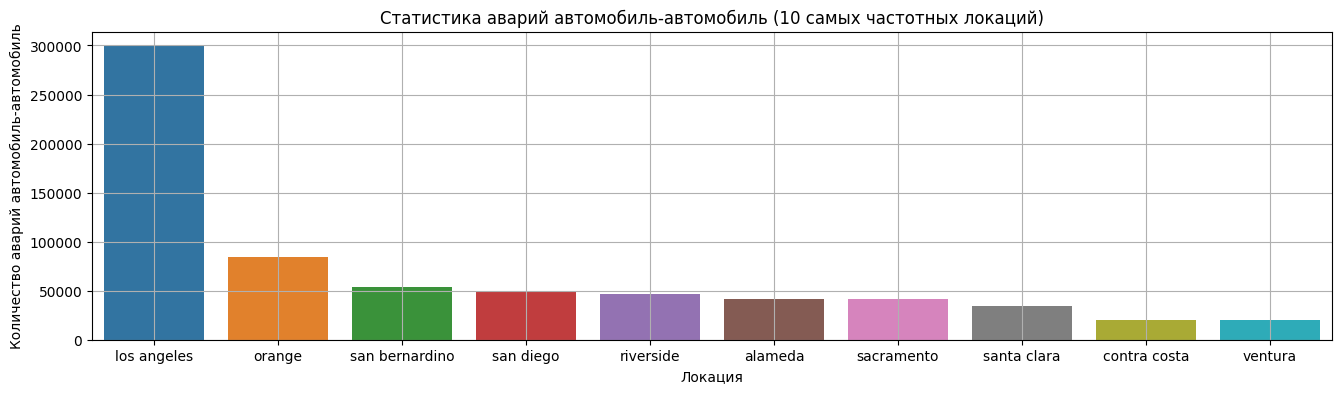

In [276]:
fig, ax = plt.subplots(figsize=(16, 4))
_ = sns.barplot(data=sql_df, x='location', y='count', ax=ax)
_ = ax.set_title('Статистика аварий автомобиль-автомобиль (10 самых частотных локаций)')
_ = ax.set_xlabel('Локация')
_ = ax.set_ylabel('Количество аварий автомобиль-автомобиль')
_ = ax.grid(True)

<b><u>Вывод:</u></b> Видим, что по количеству аварий между двумя автомобилями уверенно лидирует регион "**Лос-Анжелес**" - суммарно почти `300000` случаев ДТП. Однако теоретически это может быть связано лишь с тем, что данных по данному региону имеется значительно больше остальных. Остальные регионы представлены значительно меньше - не более `100000` ДТП.

<b>Задача 6.</b> Посмотреть на распределение среднего значения страховых премий по возрастам автомобилей в группах (`до 3 лет`, `от 3 до 5 лет`, `от 5 до 10 лет` и `старше 10 лет`) (таблицы **vehicles** и **parties**).

In [277]:
sql_df = sqlio.read_sql_query(
f"""
    SELECT
        CASE
            WHEN vhs.vehicle_age < 3 THEN '1) Меньше 3'
            WHEN vhs.vehicle_age >= 3 AND vhs.vehicle_age < 5 THEN '2) От 3 до 5'
            WHEN vhs.vehicle_age >= 5 AND vhs.vehicle_age < 10 THEN '3) От 5 до 10'
            ELSE '4) Больше 10'
        END AS vehicle_age_group,
        ROUND(MIN(pts.insurance_premium), 3) AS minimum_insurance_premium,
        ROUND(AVG(pts.insurance_premium), 3) AS average_insurance_premium,
        ROUND(MAX(pts.insurance_premium), 3) AS maximum_insurance_premium
    FROM
    (
        SELECT
            case_id,
            party_number,
            insurance_premium
        FROM parties
        WHERE insurance_premium IS NOT NULL
    ) AS pts
    INNER JOIN
    (
        SELECT
            case_id,
            party_number,
            vehicle_age
        FROM vehicles
        WHERE vehicle_age IS NOT NULL
    ) AS vhs ON pts.case_id = vhs.case_id AND pts.party_number = vhs.party_number
    GROUP BY vehicle_age_group
    ORDER BY vehicle_age_group;
""", conn)
display(sql_df)

,vehicle_age_group,minimum_insurance_premium,average_insurance_premium,maximum_insurance_premium
0,1) Меньше 3,0.00000,29.19800,105.00000
1,2) От 3 до 5,0.00000,26.31400,105.00000
2,3) От 5 до 10,0.00000,44.08600,105.00000
3,4) Больше 10,0.00000,66.21300,105.00000


Строим график (столбчатую диаграмму):

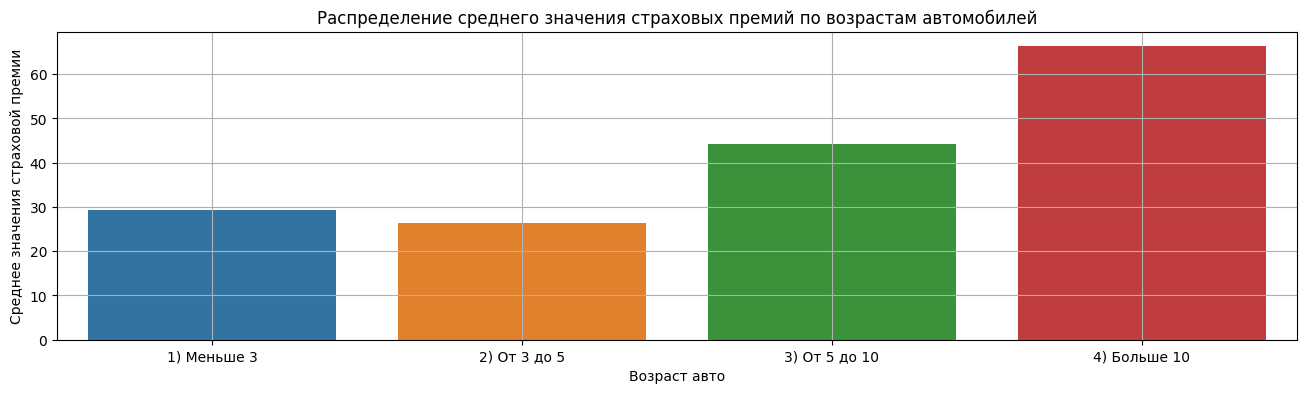

In [278]:
fig, ax = plt.subplots(figsize=(16, 4))
_ = sns.barplot(data=sql_df, x='vehicle_age_group', y='average_insurance_premium', ax=ax)
_ = ax.set_title('Распределение среднего значения страховых премий по возрастам автомобилей')
_ = ax.set_xlabel('Возраст авто')
_ = ax.set_ylabel('Среднее значения страховой премии')
_ = ax.grid(True)

На первый взгляд, результаты выглядят контр-интуитивными: с увеличением возраста автомобиля мы видим увеличение среднего значения поля `insurance_premium`, в то время как обычно имеет место тенденция с уменьшением стоимости страховки автомобиля по мере его *старения*. Судя по всему, здесь под полем `insurance_premium` понимается некоторое другое смысловое значение.

Во-первых, значения в этом поле, судя по всему, приведены в процентах. Об этом свидетельствует максиальное значение в `105` для всех наших 4 когорт. Оказывается, значение `105%` является каким-то типовым в домене страхования.

Во-вторых, [здесь](https://www.way.com/blog/how-does-the-age-of-a-car-affect-the-insurance-premiums/#How_does_the_car_insurance_premium_decrease_with_age) можно прочитать о некоторых особенностях процентного выражения `insurance_premium`, в частности:

        However, as it gets older, or after an at-fault accident, the insurance cost can increase by 93% [...] Similarly, the cost of insuring a car would only increase to even more than 105% of the car’s actual value once it crosses 15 years.

На основе этого сделаем вывод о том, что наблюдаемый феномен в распределении всё же можем иметь место в действительности.

__________

# Шаг 4. Создайте модель для оценки водительского риска

#### Шаг 4.1 Подготовьте набор данных на основе первичного предположения заказчика:

- Выберите тип виновника — только машина (**car**). **
- Возьмите случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа **SCRATCH** (царапина).
- Для моделирования возьмите данные только за `2012` год.
- Подготовка исходной таблицы должна проводиться с помощью sql-запроса.

In [279]:
sql_df = sqlio.read_sql_query(
f"""
    SELECT
        cls.case_id,
        cls.collision_damage,
        cls.county_city_location,
        cls.county_location,
        cls.distance,        
        cls.weather_1,
        cls.location_type,
        cls.road_surface,
        cls.road_condition_1,
        cls.lighting,
        cls.control_device,
        pts.party_number,
        pts.party_type,
        pts.party_sobriety,
        pts.party_drug_physical,
        pts.cellphone_in_use,
        vhs.vehicle_type,
        vhs.vehicle_transmission,
        vhs.vehicle_age,
        pts.at_fault
    FROM
    (
        SELECT
            case_id,
            county_city_location,
            county_location,
            distance,
            weather_1,
            location_type,
            road_surface,
            road_condition_1,
            lighting,
            control_device,
            collision_damage,
            collision_date
          FROM collisions
          WHERE EXTRACT(YEAR FROM collision_date) = 2012 AND collision_damage <> 'scratch'
    ) AS cls
    INNER JOIN
    (
        SELECT
            case_id,
            party_number,
            party_type,
            at_fault,
            party_sobriety,
            party_drug_physical,
            cellphone_in_use
        FROM parties
        WHERE party_type = 'car'
    ) AS pts ON cls.case_id = pts.case_id
    INNER JOIN
    (
        SELECT
            case_id,
            party_number,
            vehicle_type,
            vehicle_transmission,
            vehicle_age
        FROM vehicles
    ) AS vhs ON vhs.case_id = pts.case_id AND vhs.party_number = pts.party_number;
""", conn)
display(sql_df)

,case_id,collision_damage,county_city_location,county_location,distance,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,party_number,party_type,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,at_fault
0,5599713,small damage,3010,orange,0.00000,clear,None,dry,normal,daylight,none,1,car,impairment unknown,G,NaN,sedan,auto,3.00000,1
1,5607310,middle damage,1942,los angeles,150.00000,raining,highway,wet,normal,daylight,none,2,car,had not been drinking,None,0.00000,sedan,auto,4.00000,0
2,5610588,small damage,1942,los angeles,450.00000,clear,highway,dry,normal,daylight,none,2,car,had not been drinking,None,0.00000,sedan,auto,10.00000,0
3,5612911,small damage,3019,orange,450.00000,cloudy,highway,wet,normal,dark with no street lights,none,1,car,had not been drinking,None,0.00000,sedan,auto,4.00000,1
4,5613058,small damage,1900,los angeles,0.00000,clear,None,dry,normal,daylight,functioning,1,car,had not been drinking,None,0.00000,sedan,auto,0.00000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56243,5580052,middle damage,1905,los angeles,1000.00000,clear,None,dry,normal,dark with no street lights,none,1,car,not applicable,not applicable,0.00000,coupe,manual,3.00000,1
56244,5580093,middle damage,1942,los angeles,10.00000,clear,None,dry,normal,dark with street lights,functioning,1,car,had not been drinking,None,0.00000,coupe,auto,10.00000,0
56245,5580384,middle damage,1920,los angeles,0.00000,clear,None,dry,normal,daylight,functioning,2,car,had not been drinking,None,NaN,coupe,auto,9.00000,0
56246,5581112,middle damage,4313,santa clara,0.00000,raining,None,wet,normal,daylight,None,3,car,had not been drinking,None,NaN,coupe,auto,7.00000,0


#### Шаг 4.2 Проведите первичный отбор факторов, необходимых для модели.

Изучите описание факторов. Нужно отобрать те, которые могут влиять на вероятность ДТП. Будет хорошо, если вы аргументируете свой выбор. 

Пример:

```
columms =['party_type',     # Тип участника происшествия. Таблица parties
          'party_sobriety', # Уровень трезвости виновника (точно может влиять) Таблица parties
           ......
         ] 
```


Удалим несколько полей из выдачи выше:

- идентификатор ДТП (`case_id`) - идентификатор некоторого ДТП в прошлом никак не поможет в нашей создаваемой модели;

- степень повреждения автомобиля (`collision_damage`) - мы только предсказываем вероятность ДТП, поэтому знание о степени серьёзности некоторого прошлого ДТП, на мой взгляд, вряд ли чем-то поможет в предсказании нового ДТП, тем более, что нам просто негде будет взять значение данного признака для прогона модели на новых данных;

- номеры стороны ДТП по порядку (`party_number`) - аналогично полю `case_id`, сам по себе идентификатор нам никак не поможет;

- тип стороны-участницы ДТП (`party_type`) - у нас и так был произведён отбор по `party_type = car`, так что данное поле тоже является бесполезным;

In [280]:
sql_df.drop(['case_id', 'collision_damage', 'party_number', 'party_type'], axis=1, inplace=True)

# Заодно переименуем несколько колонок, убрав из них "_1"
sql_df.rename(columns={'weather_1': 'weather', 'road_condition_1': 'road_condition'}, inplace=True)
display(sql_df)

,county_city_location,county_location,distance,weather,location_type,road_surface,road_condition,lighting,control_device,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,at_fault
0,3010,orange,0.00000,clear,None,dry,normal,daylight,none,impairment unknown,G,NaN,sedan,auto,3.00000,1
1,1942,los angeles,150.00000,raining,highway,wet,normal,daylight,none,had not been drinking,None,0.00000,sedan,auto,4.00000,0
2,1942,los angeles,450.00000,clear,highway,dry,normal,daylight,none,had not been drinking,None,0.00000,sedan,auto,10.00000,0
3,3019,orange,450.00000,cloudy,highway,wet,normal,dark with no street lights,none,had not been drinking,None,0.00000,sedan,auto,4.00000,1
4,1900,los angeles,0.00000,clear,None,dry,normal,daylight,functioning,had not been drinking,None,0.00000,sedan,auto,0.00000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56243,1905,los angeles,1000.00000,clear,None,dry,normal,dark with no street lights,none,not applicable,not applicable,0.00000,coupe,manual,3.00000,1
56244,1942,los angeles,10.00000,clear,None,dry,normal,dark with street lights,functioning,had not been drinking,None,0.00000,coupe,auto,10.00000,0
56245,1920,los angeles,0.00000,clear,None,dry,normal,daylight,functioning,had not been drinking,None,NaN,coupe,auto,9.00000,0
56246,4313,santa clara,0.00000,raining,None,wet,normal,daylight,None,had not been drinking,None,NaN,coupe,auto,7.00000,0


In [281]:
# Итого, мы остались со следующими полями:
columns =\
[
    'county_city_location', # Округ (в числовом, более детальном представлении)
    'county_location',      # Округ (в строковом представлении)
    'distance',             # Расстояние поездки
    'weather',              # Погода
    'location_type',        # Тип местоположения
    'road_surface',         # Дорожное покрытие
    'road_condition',       # Состояние дороги
    'lighting',             # Освещение
    'control_device',       # Устройство управления
    'party_sobriety',       # Выпивал ли водитель перед поездкой
    'party_drug_physical',  # Состояние водителя (под воздействием ли он лекарственных или наркотических препаратов)
    'vehicle_type',         # Тип кузова автомобиля
    'vehicle_transmission', # Тип трансмиссия автомобиля
    'vehicle_age',          # Возраст автомобиля
    'cellphone_in_use',     # В авто есть громкая связь
    'at_fault'              # Целевая переменная
]

display(sql_df[columns])

,county_city_location,county_location,distance,weather,location_type,road_surface,road_condition,lighting,control_device,party_sobriety,party_drug_physical,vehicle_type,vehicle_transmission,vehicle_age,cellphone_in_use,at_fault
0,3010,orange,0.00000,clear,None,dry,normal,daylight,none,impairment unknown,G,sedan,auto,3.00000,NaN,1
1,1942,los angeles,150.00000,raining,highway,wet,normal,daylight,none,had not been drinking,None,sedan,auto,4.00000,0.00000,0
2,1942,los angeles,450.00000,clear,highway,dry,normal,daylight,none,had not been drinking,None,sedan,auto,10.00000,0.00000,0
3,3019,orange,450.00000,cloudy,highway,wet,normal,dark with no street lights,none,had not been drinking,None,sedan,auto,4.00000,0.00000,1
4,1900,los angeles,0.00000,clear,None,dry,normal,daylight,functioning,had not been drinking,None,sedan,auto,0.00000,0.00000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56243,1905,los angeles,1000.00000,clear,None,dry,normal,dark with no street lights,none,not applicable,not applicable,coupe,manual,3.00000,0.00000,1
56244,1942,los angeles,10.00000,clear,None,dry,normal,dark with street lights,functioning,had not been drinking,None,coupe,auto,10.00000,0.00000,0
56245,1920,los angeles,0.00000,clear,None,dry,normal,daylight,functioning,had not been drinking,None,coupe,auto,9.00000,NaN,0
56246,4313,santa clara,0.00000,raining,None,wet,normal,daylight,None,had not been drinking,None,coupe,auto,7.00000,NaN,0


#### Шаг 4.3 Проведите статистическое исследование отобранных факторов.

Начнём с вывода общей информации по набору данных:

In [282]:
pd.set_option('display.float_format', lambda x: '%.5f' % x) # для вывода вещественных чисел без экспоненты

display(sql_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county_city_location  56248 non-null  object 
 1   county_location       56248 non-null  object 
 2   distance              56248 non-null  float64
 3   weather               56080 non-null  object 
 4   location_type         25932 non-null  object 
 5   road_surface          55900 non-null  object 
 6   road_condition        55999 non-null  object 
 7   lighting              56094 non-null  object 
 8   control_device        56033 non-null  object 
 9   party_sobriety        55376 non-null  object 
 10  party_drug_physical   2857 non-null   object 
 11  cellphone_in_use      51777 non-null  float64
 12  vehicle_type          56248 non-null  object 
 13  vehicle_transmission  55389 non-null  object 
 14  vehicle_age           54554 non-null  float64
 15  at_fault           

None

Замечаем, что:
    
- в наборе `56248` оразцов;

- числовых полей (за исключением целевого столбца `at_fault` и столбца `cellphone_in_use`, который по своему смыслу бинарный) всего 2 - `distance` и `vehicle_age`. Поле `county_city_location` хоть и представлено числовым кодом, но является категориальным по своей сути;

Теперь заменим все спец-символы на символы подчёркивания во всех строковых столцах:

In [283]:
display(sql_df)

for col in columns:
    import re
    sql_df[col] = sql_df[col].apply(lambda x: re.sub('[^A-Za-z0-9]+', '_', x) if type(x) == str else x)

display(sql_df)

,county_city_location,county_location,distance,weather,location_type,road_surface,road_condition,lighting,control_device,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,at_fault
0,3010,orange,0.00000,clear,None,dry,normal,daylight,none,impairment unknown,G,NaN,sedan,auto,3.00000,1
1,1942,los angeles,150.00000,raining,highway,wet,normal,daylight,none,had not been drinking,None,0.00000,sedan,auto,4.00000,0
2,1942,los angeles,450.00000,clear,highway,dry,normal,daylight,none,had not been drinking,None,0.00000,sedan,auto,10.00000,0
3,3019,orange,450.00000,cloudy,highway,wet,normal,dark with no street lights,none,had not been drinking,None,0.00000,sedan,auto,4.00000,1
4,1900,los angeles,0.00000,clear,None,dry,normal,daylight,functioning,had not been drinking,None,0.00000,sedan,auto,0.00000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56243,1905,los angeles,1000.00000,clear,None,dry,normal,dark with no street lights,none,not applicable,not applicable,0.00000,coupe,manual,3.00000,1
56244,1942,los angeles,10.00000,clear,None,dry,normal,dark with street lights,functioning,had not been drinking,None,0.00000,coupe,auto,10.00000,0
56245,1920,los angeles,0.00000,clear,None,dry,normal,daylight,functioning,had not been drinking,None,NaN,coupe,auto,9.00000,0
56246,4313,santa clara,0.00000,raining,None,wet,normal,daylight,None,had not been drinking,None,NaN,coupe,auto,7.00000,0


,county_city_location,county_location,distance,weather,location_type,road_surface,road_condition,lighting,control_device,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,at_fault
0,3010,orange,0.00000,clear,None,dry,normal,daylight,none,impairment_unknown,G,NaN,sedan,auto,3.00000,1
1,1942,los_angeles,150.00000,raining,highway,wet,normal,daylight,none,had_not_been_drinking,None,0.00000,sedan,auto,4.00000,0
2,1942,los_angeles,450.00000,clear,highway,dry,normal,daylight,none,had_not_been_drinking,None,0.00000,sedan,auto,10.00000,0
3,3019,orange,450.00000,cloudy,highway,wet,normal,dark_with_no_street_lights,none,had_not_been_drinking,None,0.00000,sedan,auto,4.00000,1
4,1900,los_angeles,0.00000,clear,None,dry,normal,daylight,functioning,had_not_been_drinking,None,0.00000,sedan,auto,0.00000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56243,1905,los_angeles,1000.00000,clear,None,dry,normal,dark_with_no_street_lights,none,not_applicable,not_applicable,0.00000,coupe,manual,3.00000,1
56244,1942,los_angeles,10.00000,clear,None,dry,normal,dark_with_street_lights,functioning,had_not_been_drinking,None,0.00000,coupe,auto,10.00000,0
56245,1920,los_angeles,0.00000,clear,None,dry,normal,daylight,functioning,had_not_been_drinking,None,NaN,coupe,auto,9.00000,0
56246,4313,santa_clara,0.00000,raining,None,wet,normal,daylight,None,had_not_been_drinking,None,NaN,coupe,auto,7.00000,0


________________

Теперь более детально рассмотрим каждый из столбцов-факторов:

#### Фактор `county_city_location`

Фактор хоть и представлен числом, но является категориальным по своей сути, поэтому изучим возможные принимаемые значения для данного поля.

In [284]:
print(sql_df['county_city_location'].unique())
print(sql_df['county_city_location'].value_counts())

['3010' '1942' '3019' '1900' '1906' '1929' '3604' '1992' '1500' '4311'
 '3103' '5704' '3404' '4900' '1949' '3900' '3394' '3318' '3300' '0105'
 '5600' '3400' '3600' '3619' '3801' '5604' '4806' '4313' '3001' '1955'
 '1990' '3616' '4116' '0400' '5607' '3313' '1965' '3712' '3026' '3905'
 '2100' '2000' '1922' '0900' '0708' '3709' '3621' '5200' '3703' '3000'
 '5002' '3002' '2300' '0402' '5000' '1967' '1964' '3105' '5703' '4500'
 '3015' '2800' '1928' '5400' '1001' '4300' '4000' '1959' '1977' '4400'
 '3700' '4316' '3711' '1985' '0113' '4100' '1944' '1931' '1909' '1932'
 '0102' '3607' '3004' '4103' '3011' '1920' '3341' '0100' '0700' '1502'
 '1926' '1975' '1934' '3007' '1912' '5700' '2106' '4113' '5202' '1000'
 '3713' '5800' '5609' '1506' '3009' '3024' '2700' '1005' '3028' '1941'
 '4803' '3640' '3016' '3017' '3008' '3612' '0710' '2002' '4204' '2109'
 '3450' '5601' '1979' '2001' '1507' '3906' '0702' '1600' '1962' '0109'
 '0800' '3029' '2600' '4110' '3311' '0104' '1946' '4104' '1400' '4315'
 '4120

Видим огромное количество возможных значений - `496`, в то же время сами значения (их строки) выглядят адекватно. Вряд ли можно говорить о возможности One-Hot кодирования данного столбца из-за такое большой вариативности, в то же время, возможно будет задуматься об использовании столбца в моделях градиентного бустинга, не требующих данное кодирование.

__________

#### Фактор `county_location`

In [285]:
print(sql_df['county_location'].unique())
print(sql_df['county_location'].value_counts())
print(f'Количество уникальных значений в столбце {"county_location"}: {len(sql_df["county_location"].unique())}')

['orange' 'los_angeles' 'san_bernardino' 'kern' 'santa_clara' 'placer'
 'yolo' 'sacramento' 'sonoma' 'san_joaquin' 'riverside' 'alameda'
 'ventura' 'san_francisco' 'solano' 'san_mateo' 'butte' 'san_diego'
 'marin' 'madera' 'el_dorado' 'contra_costa' 'tehama' 'stanislaus'
 'mendocino' 'shasta' 'napa' 'tulare' 'fresno' 'san_luis_obispo'
 'santa_cruz' 'yuba' 'monterey' 'santa_barbara' 'kings' 'del_norte' 'mono'
 'inyo' 'plumas' 'lassen' 'siskiyou' 'lake' 'trinity' 'calaveras' 'nevada'
 'merced' 'humboldt' 'glenn' 'tuolumne' 'sutter' 'colusa' 'amador'
 'imperial' 'san_benito' 'mariposa' 'modoc' 'alpine' 'sierra']
los_angeles        16236
orange              5364
san_diego           3740
san_bernardino      3649
riverside           3313
sacramento          2185
alameda             1876
santa_clara         1845
ventura             1466
kern                1415
fresno              1073
contra_costa         990
san_mateo            938
san_joaquin          936
stanislaus           805
santa_ba

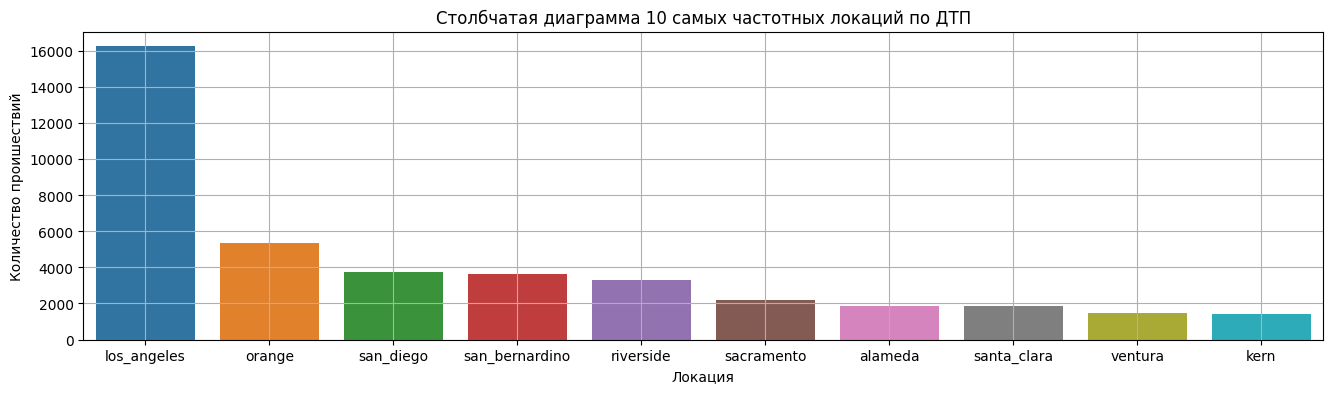

In [286]:
county_location = sql_df['county_location'].value_counts().iloc[:10]

fig, ax = plt.subplots(figsize=(16, 4))
_ = sns.barplot(x=county_location.index, y=county_location.values, ax=ax)
_ = ax.set_title('Столбчатая диаграмма 10 самых частотных локаций по ДТП')
_ = ax.set_xlabel('Локация')
_ = ax.set_ylabel('Количество проишествий')
_ = ax.grid(True)

Уникальных значений здесь уже меньше - `58` локаций, возможно будет попробовать сделать One-Hot кодирование данного столбца. Огромное количество данных о проишествиях имеется по Лос-Анжелесу, на втором месте регион "_Orange_", по которому данных уже примерно втрое меньше. Разрывы между следующими регионами не такие значительные.

___________________

### Фактор `distance`

In [287]:
display(sql_df['distance'].describe())

count     56248.00000
mean        859.43872
std        7240.29518
min           0.00000
25%           7.00000
50%         135.00000
75%         545.00000
max     1584000.00000
Name: distance, dtype: float64

Минимальное значение равно `0`, что, очевидно, означает движение по главной дороге. И первый квартиль тоже очень мал - `7`. Также сразу можно заметить, насколько среднее значение (`859.4`) превосходит медиану (`135.0`) - распределение смещено вправо, в нём есть явные выбросы с очень большим значением расстояния до главной дороги.

Для начала определим количество данных с нулевым значением фактора `distance`:

In [288]:
print(f'Число наблюдений с нулевым значением признака "distance":\n\t{sql_df[sql_df["distance"] == 0]["distance"].count()}')

Число наблюдений с нулевым значением признака "distance":
	13227


Итого, у нас `13227` нулевых наблюдений, что, конечно, очень много.

Теперт построим несколько графиков:

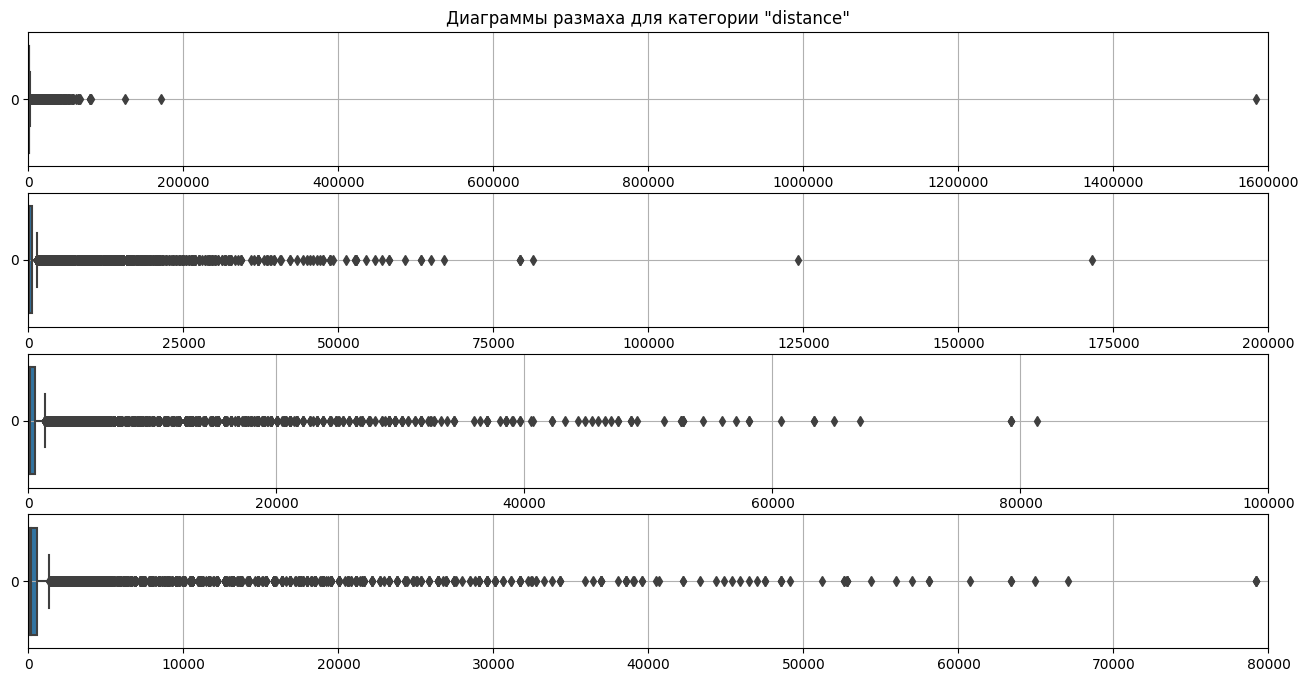

In [289]:
x_lims = [1_600_000, 200_000, 100_000, 80_000]
fig, axes = plt.subplots(figsize=(16, 8), ncols=1, nrows=len(x_lims))
for i in range(len(x_lims)):
    x_lim = x_lims[i]
    ax = axes[i]
    if i == 0:
        _ = ax.set_title('Диаграммы размаха для категории "distance"')
    _ = sns.boxplot(sql_df['distance'], orient='h', ax=ax)
    _ = ax.set(xlim=(0, x_lim))
    _ = ax.ticklabel_format(style='plain', axis='x')
    _ = ax.grid(True)

Видим, что выбросы есть, будем избавляться от них ниже.

________________

#### Фактор `weather`

In [290]:
weather = sql_df['weather'].value_counts(dropna=False)
print(sql_df['weather'].unique())
print(weather)

['clear' 'raining' 'cloudy' 'fog' None 'snowing' 'other' 'wind']
clear      45092
cloudy      8427
raining     2178
fog          181
NaN          168
snowing      157
other         34
wind          11
Name: weather, dtype: int64


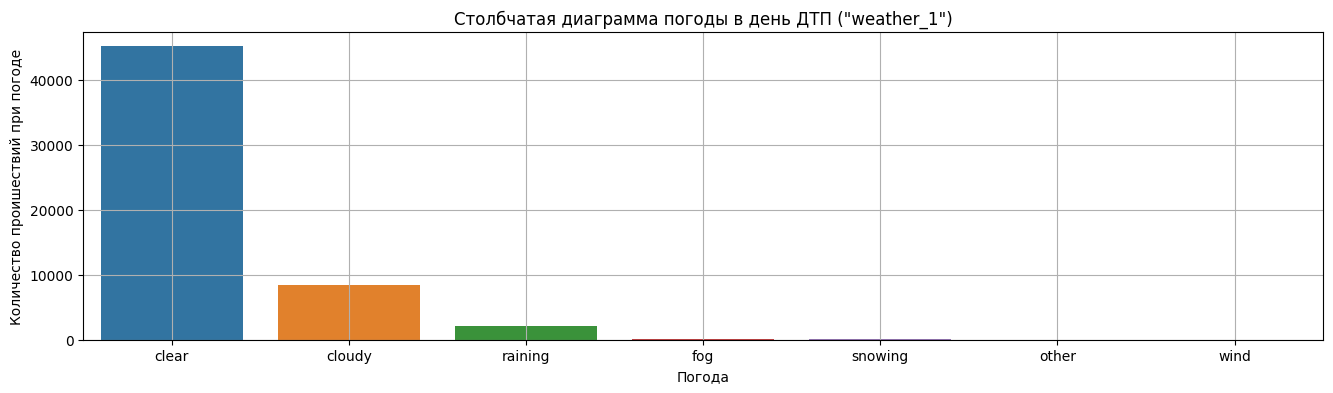

In [291]:
fig, ax = plt.subplots(figsize=(16, 4))
_ = sns.barplot(x=weather.index, y=weather.values, ax=ax)
_ = ax.set_title('Столбчатая диаграмма погоды в день ДТП ("weather_1")')
_ = ax.set_xlabel('Погода')
_ = ax.set_ylabel('Количество проишествий при погоде')
_ = ax.grid(True)

Большинство ДТП было совершено при "_чистой_" (_clear_) погоде. В столбце есть пропуски - значение `None`, их `168` штук. Это немного, поэтому, возможно, можно просто пренебречь ими и удалить соответствующие строки из набора данных.

___________

#### Фактор `location_type`

In [292]:
location_type_with_nones = sql_df['location_type'].value_counts(dropna=False).reset_index().fillna('none')
display(location_type_with_nones)

,index,location_type
0,none,30316
1,highway,21323
2,ramp,3267
3,intersection,1342


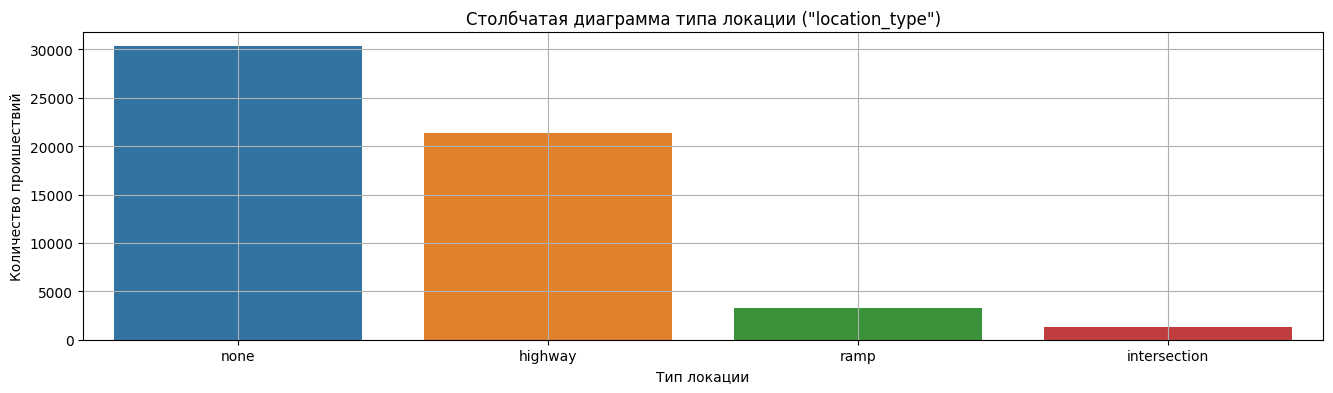

In [293]:
fig, ax = plt.subplots(figsize=(16, 4))
_ = sns.barplot(x=location_type_with_nones['index'], y=location_type_with_nones['location_type'], ax=ax)
_ = ax.set_title('Столбчатая диаграмма типа локации ("location_type")')
_ = ax.set_xlabel('Тип локации')
_ = ax.set_ylabel('Количество проишествий')
_ = ax.grid(True)

В поле есть пропуски, и их очень много - больше `30000`. Возможно, их можно было бы заменить на условное значение `no_information`. В то же время различных значений в поле всего `3`. Вообще смысл столбца не очень понятен - ведь на маршруте могут быть и магистрали  (`highway`), и скаты/спуски (`ramp`), и перекрёстки (`intersection`). Всё это наводит на мысль о том, что данный столбец не может нам помочь в построении требуемой модели, однако, пока оставим его, а окончательное решение примем позже.

______________

#### Фактор `road_surface`

In [294]:
road_surface_with_nones = sql_df['road_surface'].value_counts(dropna=False).reset_index().fillna('none')
display(road_surface_with_nones)

,index,road_surface
0,dry,50242
1,wet,5258
2,snowy,357
3,none,348
4,slippery,43


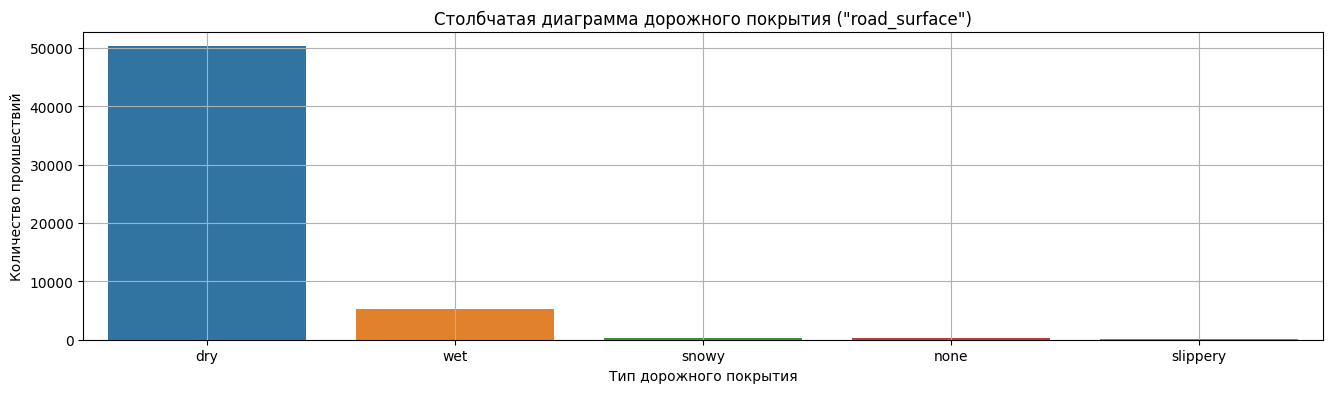

In [295]:
fig, ax = plt.subplots(figsize=(16, 4))
_ = sns.barplot(x=road_surface_with_nones['index'], y=road_surface_with_nones['road_surface'], ax=ax)
_ = ax.set_title('Столбчатая диаграмма дорожного покрытия ("road_surface")')
_ = ax.set_xlabel('Тип дорожного покрытия')
_ = ax.set_ylabel('Количество проишествий')
_ = ax.grid(True)

Большинство проишествий произошли на сухом дорожном покрытии, их больше `50000`. Пропуски в данном столбце также есть, но их немного, скорее всего ими можно пожертвовать, удалив соответствующие наблюдения из набора данных.

___________

#### Фактор `road_condition`

In [296]:
road_condition_with_nones = sql_df['road_condition'].value_counts(dropna=False).reset_index().fillna('none')
display(road_condition_with_nones)

,index,road_condition
0,normal,54066
1,construction,1003
2,none,249
3,obstruction,248
4,other,228
5,holes,222
6,loose_material,128
7,reduced_width,72
8,flooded,32


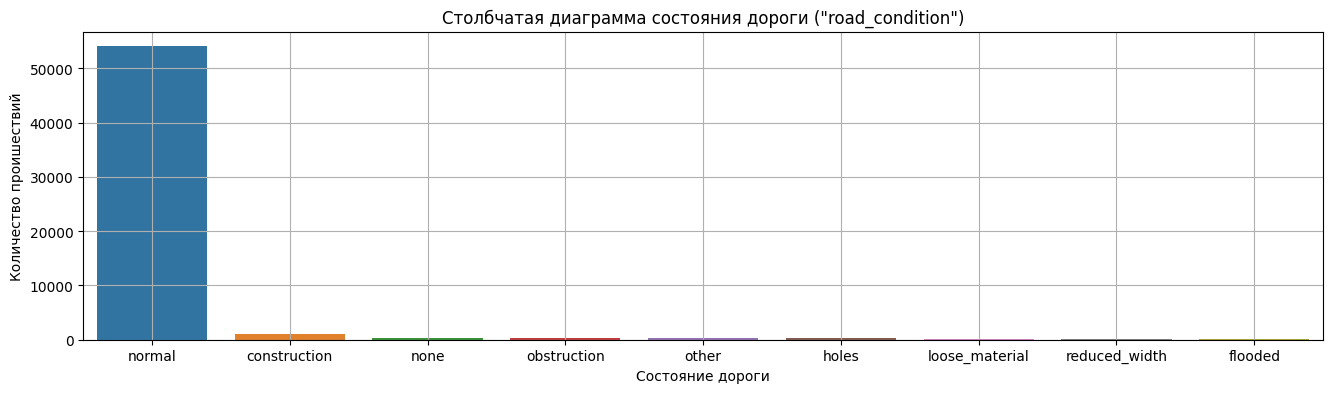

In [297]:
fig, ax = plt.subplots(figsize=(16, 4))
_ = sns.barplot(x=road_condition_with_nones['index'], y=road_condition_with_nones['road_condition'], ax=ax)
_ = ax.set_title('Столбчатая диаграмма состояния дороги ("road_condition")')
_ = ax.set_xlabel('Состояние дороги')
_ = ax.set_ylabel('Количество проишествий')
_ = ax.grid(True)

Подавляющиее большинство наблюдений относятся к нормальному состоянию дороги. Есть `193` пропуска - их будем удалять.

_______________

#### Фактор `lighting`

In [298]:
lighting_with_nones = sql_df['lighting'].value_counts(dropna=False).reset_index().fillna('none')
display(lighting_with_nones)

,index,lighting
0,daylight,38064
1,dark_with_street_lights,11017
2,dark_with_no_street_lights,5109
3,dusk_or_dawn,1769
4,none,154
5,dark_with_street_lights_not_functioning,135


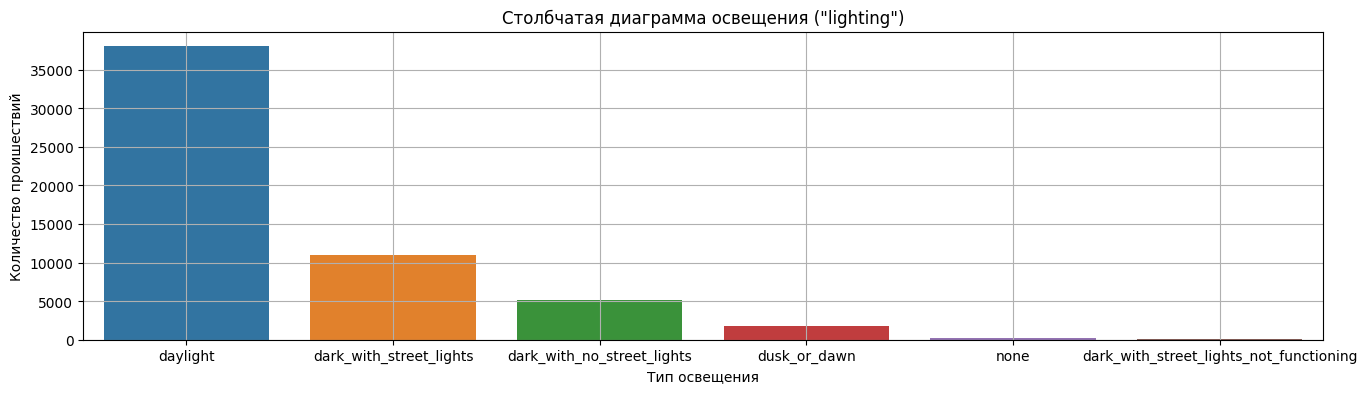

In [299]:
fig, ax = plt.subplots(figsize=(16, 4))
_ = sns.barplot(x=lighting_with_nones['index'], y=lighting_with_nones['lighting'], ax=ax)
_ = ax.set_title('Столбчатая диаграмма освещения ("lighting")')
_ = ax.set_xlabel('Тип освещения')
_ = ax.set_ylabel('Количество проишествий')
_ = ax.grid(True)

Ситуация схожа с типом дорожного покрытия: большинство проишествий произошло во время дневного освещения. Снова наблюдается небольшое количество пропусков, которыми скорее всего можно будет пожертвовать.

_______________

#### Фактор `control_device`

In [300]:
control_device_with_nones = sql_df['control_device'].value_counts(dropna=False).reset_index().fillna('missed')
display(control_device_with_nones)

,index,control_device
0,none,37578
1,functioning,18310
2,missed,215
3,not_functioning,116
4,obscured,29


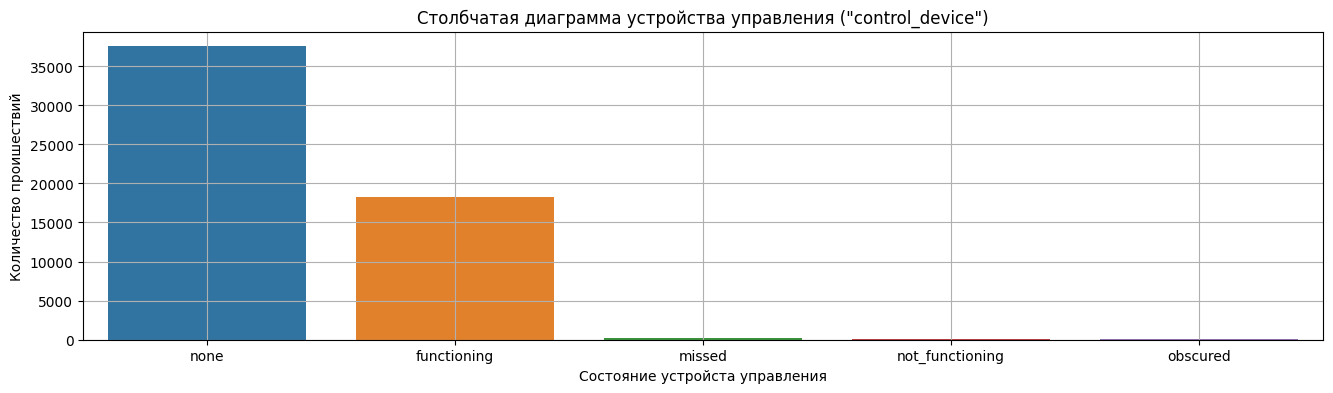

In [301]:
fig, ax = plt.subplots(figsize=(16, 4))
_ = sns.barplot(x=control_device_with_nones['index'], y=control_device_with_nones['control_device'], ax=ax)
_ = ax.set_title('Столбчатая диаграмма устройства управления ("control_device")')
_ = ax.set_xlabel('Состояние устройста управления')
_ = ax.set_ylabel('Количество проишествий')
_ = ax.grid(True)

Пропуском здесь является значение `missed`, их `215`, нужно будет их удалить ниже. Значение `none`, которое самое частотное в данном распределении, не является пропуском.

_______________

#### Фактор `party_sobriety`

In [302]:
party_sobriety_with_nones = sql_df['party_sobriety'].value_counts(dropna=False).reset_index().fillna('none')
display(party_sobriety_with_nones)

,index,party_sobriety
0,had_not_been_drinking,48577
1,had_been_drinking_under_influence,4475
2,impairment_unknown,1238
3,none,872
4,had_been_drinking_not_under_influence,575
5,had_been_drinking_impairment_unknown,261
6,not_applicable,250


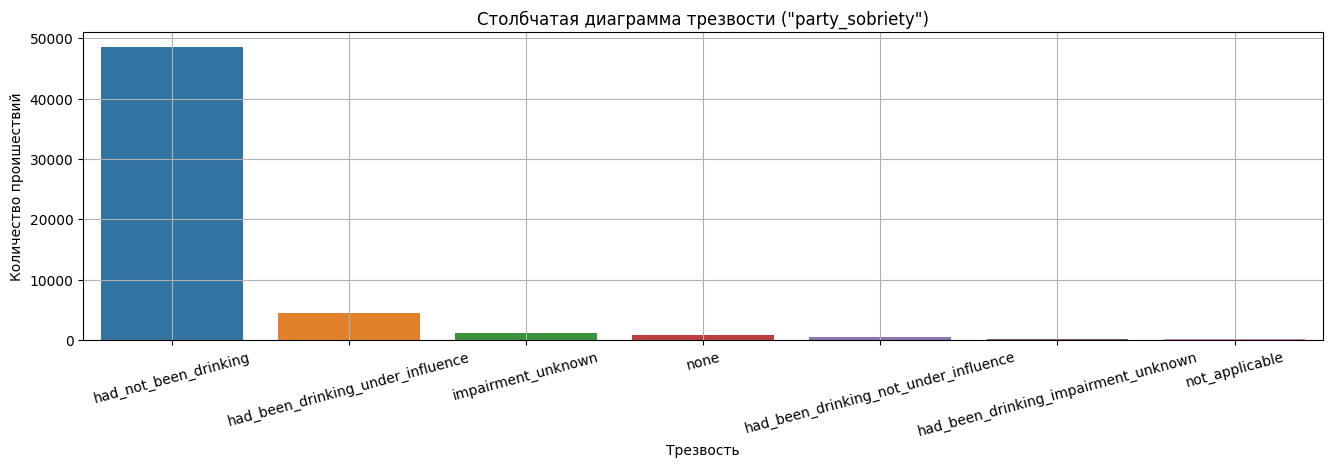

In [303]:
fig, ax = plt.subplots(figsize=(16, 4))
_ = sns.barplot(x=party_sobriety_with_nones['index'], y=party_sobriety_with_nones['party_sobriety'], ax=ax)
_ = ax.set_title('Столбчатая диаграмма трезвости ("party_sobriety")')
_ = ax.set_xlabel('Трезвость')
_ = ax.set_ylabel('Количество проишествий')
_ = ax.tick_params(axis='x', rotation=15) 
_ = ax.grid(True)

Пропусков не очень много, возможно, ими можно пожертвовать. В теории можно было бы попробовать организовать некоторый числовой порядок по степени опъянения, который можно было бы использовать для сравнения посредством "_больше_" / "_меньше_", однако пока не будем этого делать.

__________

#### Фактор `party_drug_physical`

In [304]:
party_drug_physical_with_nones = sql_df['party_drug_physical'].value_counts(dropna=False).reset_index().fillna('none')
display(party_drug_physical_with_nones)

,index,party_drug_physical
0,none,53391
1,G,1238
2,under_drug_influence,857
3,sleepy_fatigued,390
4,not_applicable,250
5,impairment_physical,122


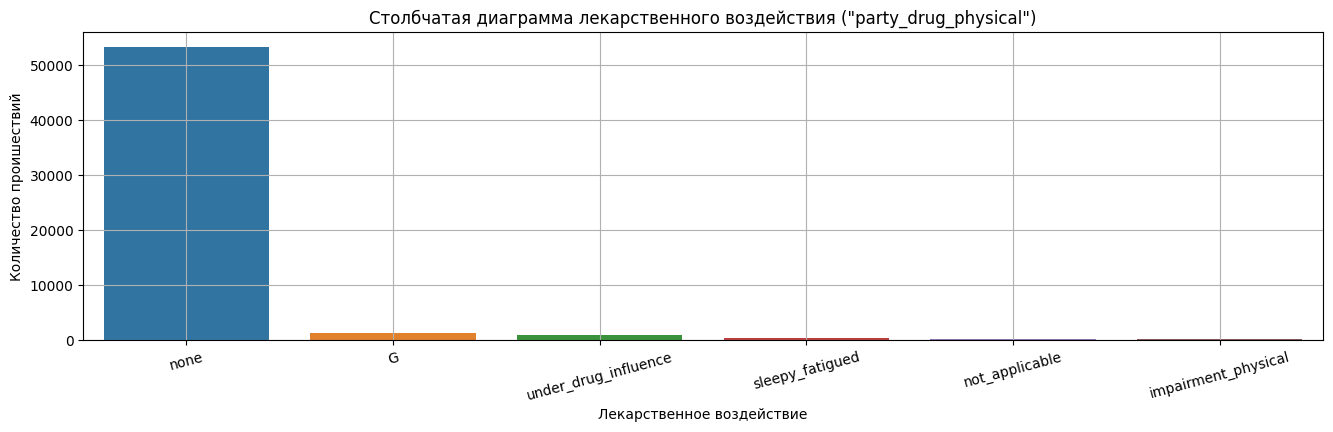

In [305]:
fig, ax = plt.subplots(figsize=(16, 4))
_ = sns.barplot(x=party_drug_physical_with_nones['index'], y=party_drug_physical_with_nones['party_drug_physical'], ax=ax)
_ = ax.set_title('Столбчатая диаграмма лекарственного воздействия ("party_drug_physical")')
_ = ax.set_xlabel('Лекарственное воздействие')
_ = ax.set_ylabel('Количество проишествий')
_ = ax.tick_params(axis='x', rotation=15) 
_ = ax.grid(True)

Пропуски здесь представляют собой подавляющее большинство распределения. Судя по всему, они соответствуют отсутствию какого-либо эффекта от лекарственного воздействия, так что удалять данные с такими пропусками не целесообразно.

__________

#### Фактор `cellphone_in_use`

In [306]:
cellphone_in_use_with_nones = sql_df['cellphone_in_use'].value_counts(dropna=False).reset_index().fillna('none')
display(cellphone_in_use_with_nones)

,index,cellphone_in_use
0,0.00000,50723
1,none,4471
2,1.00000,1054


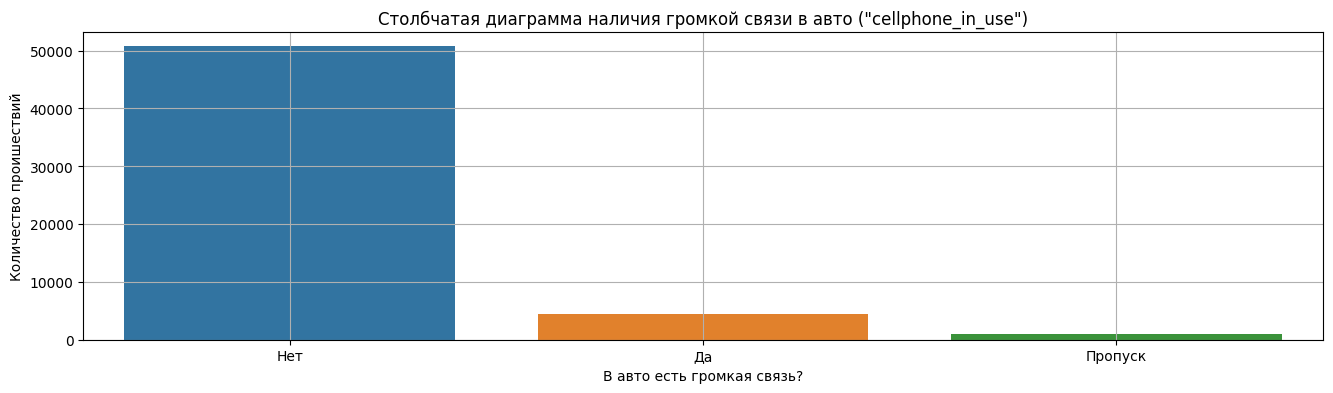

In [307]:
fig, ax = plt.subplots(figsize=(16, 4))
_ = sns.barplot(x=cellphone_in_use_with_nones['index'], y=cellphone_in_use_with_nones['cellphone_in_use'], ax=ax)
_ = ax.set_title('Столбчатая диаграмма наличия громкой связи в авто ("cellphone_in_use")')
_ = ax.set_xlabel('В авто есть громкая связь?')
_ = ax.set_ylabel('Количество проишествий')
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Нет'
labels[1] = 'Да'
labels[2] = 'Пропуск'
_ = ax.set_xticklabels(labels)
_ = ax.grid(True)

Видим большое количество пропусков - `4471` записей.

Удалять такое количество данных жалко, поэтому будем исходить из предположения, что <b><u>пропуск для данной категории означает отсутствие устройства для громкой связи, т.е. значение `Нет`, тем более что оно является гораздо более частотным</b></u>.

______________

#### Фактор `vehicle_type`

In [308]:
vehicle_type = sql_df['vehicle_type'].value_counts(dropna=False).reset_index().fillna('none')
display(vehicle_type)

,index,vehicle_type
0,sedan,37180
1,coupe,19064
2,other,4


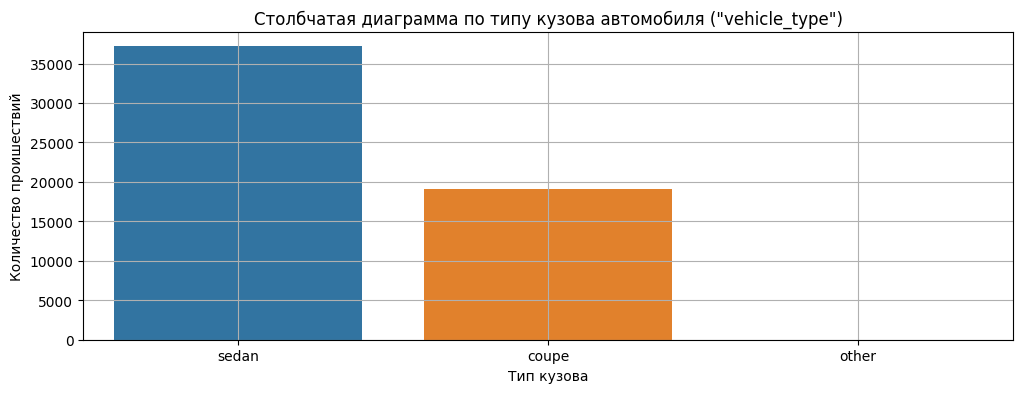

In [309]:
fig, ax = plt.subplots(figsize=(12, 4))
_ = sns.barplot(x=vehicle_type['index'], y=vehicle_type['vehicle_type'], ax=ax)
_ = ax.set_title('Столбчатая диаграмма по типу кузова автомобиля ("vehicle_type")')
_ = ax.set_xlabel('Тип кузова')
_ = ax.set_ylabel('Количество проишествий')
_ = ax.grid(True)

Пропусков в факторе `vehicle_type` нету. Типов кузова по сути два, при этом седанов примерно вдвое больше, чем купе.

______________

#### Фактор `vehicle_transmission`

In [310]:
vehicle_transmission = sql_df['vehicle_transmission'].value_counts(dropna=False).reset_index().fillna('none')
display(vehicle_transmission)

,index,vehicle_transmission
0,manual,29318
1,auto,26071
2,none,859


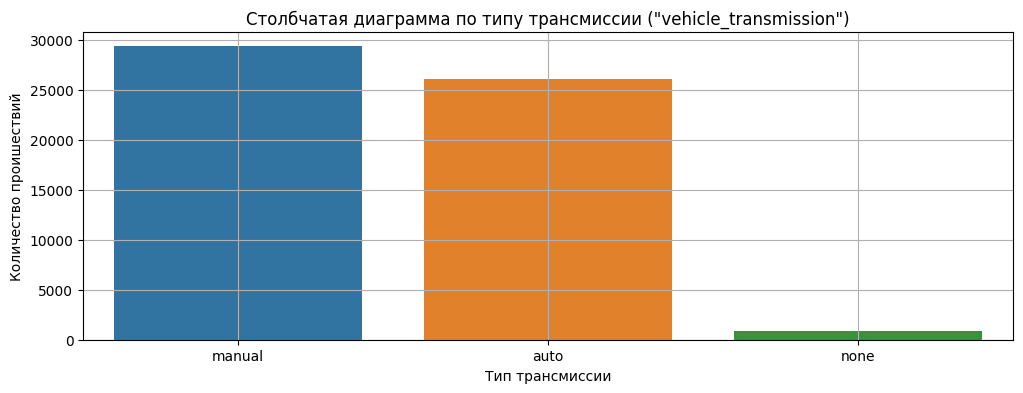

In [311]:
fig, ax = plt.subplots(figsize=(12, 4))
_ = sns.barplot(x=vehicle_transmission['index'], y=vehicle_transmission['vehicle_transmission'], ax=ax)
_ = ax.set_title('Столбчатая диаграмма по типу трансмиссии ("vehicle_transmission")')
_ = ax.set_xlabel('Тип трансмиссии')
_ = ax.set_ylabel('Количество проишествий')
_ = ax.grid(True)

Автоматическая трансмисиия представлена почти так же, как и ручная. Имеются пропуски в количестве `859` штук, возможно, такими данными нужно будет пожертвовать, удалив их.

__________

#### Фактор `vehicle_age`

In [312]:
display(sql_df['vehicle_age'].describe())

count   54554.00000
mean        4.85647
std         3.23450
min         0.00000
25%         3.00000
50%         4.00000
75%         7.00000
max       161.00000
Name: vehicle_age, dtype: float64

Медиана вновь отстаёт от среднего, но не так значительно: `4.0` против `4.8`. Максимальное значение при этом равно `161`, что выглядит явным выбросом для нас. Едва ли создаваемой модели предстоит иметь дело со случаями настолько старых автомобилей.

Оценим количество авто с нулевым возрастом:

In [313]:
print(f'Число наблюдений с нулевым значением признака "distance":\n\t{sql_df[sql_df["vehicle_age"] == 0]["vehicle_age"].count()}')

Число наблюдений с нулевым значением признака "distance":
	3087


Назвать их выбросами вряд ли стоит - скорее это автомобили, не достигшие года по своему возрасту, и их заметное количество.

Построим диаграммы размаха:

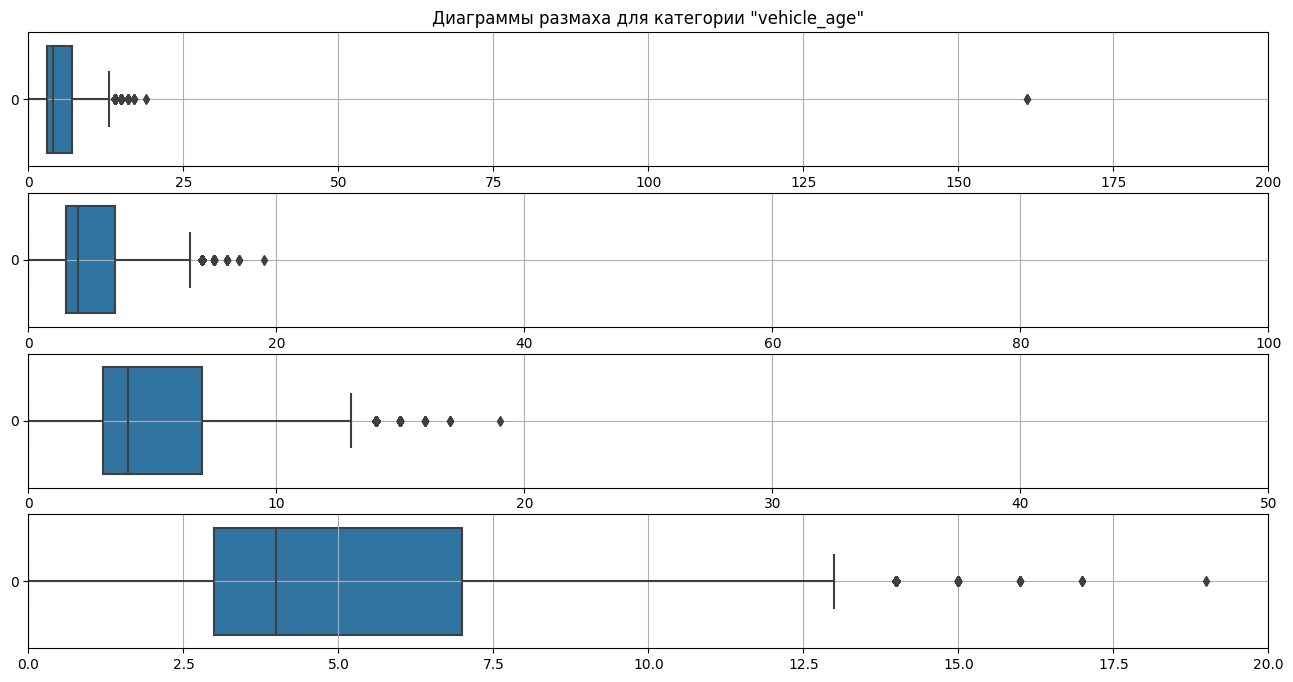

In [314]:
x_lims = [200, 100, 50, 20]
fig, axes = plt.subplots(figsize=(16, 8), ncols=1, nrows=len(x_lims))
for i in range(len(x_lims)):
    x_lim = x_lims[i]
    ax = axes[i]
    if i == 0:
        _ = ax.set_title('Диаграммы размаха для категории "vehicle_age"')
    _ = sns.boxplot(sql_df['vehicle_age'], orient='h', ax=ax)
    _ = ax.set(xlim=(0, x_lim))
    _ = ax.ticklabel_format(style='plain', axis='x')
    _ = ax.grid(True)

Судя по графикам, верхней границей можно посчитать `15` лет, а все автомобили, которые старше этого возраста, можно удалить, посчитав их выбросами.

____________

#### Фактор `at_fault`

Теперь посмотрим на нашу целевую переменную:

In [315]:
at_fault = sql_df['at_fault'].value_counts()
display(at_fault)

1    28373
0    27875
Name: at_fault, dtype: int64

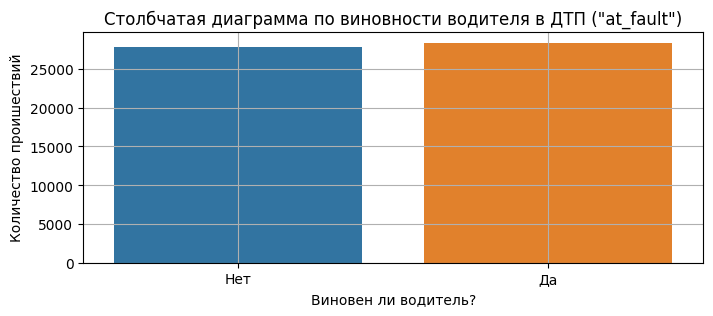

In [316]:
fig, ax = plt.subplots(figsize=(8, 3))
_ = sns.barplot(x=at_fault.index, y=at_fault.values, ax=ax)
_ = ax.set_title('Столбчатая диаграмма по виновности водителя в ДТП ("at_fault")')
_ = ax.set_xlabel('Виновен ли водитель?')
_ = ax.set_ylabel('Количество проишествий')
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Нет'
labels[1] = 'Да'
_ = ax.set_xticklabels(labels)
_ = ax.grid(True)

Распределение нашего целевого бинарного признака демонстрирует удивительную равномерность - случаев виновных и невиновных водителей примерно поровну в нашем наборе данных.

______________

#### Шаг 4.3.1 По результату исследовательского анализа внесите корректировки, если они нужны. Сделайте вывод.

Оценим размерность нашего набора данных до корректировок:

In [317]:
dataset_shape_before = sql_df.shape
print(dataset_shape_before)

(56248, 16)


### Фактор `distance`
Выбросы у данного фактора есть, будем избавляться от них.
Оценим, сколько есть данных с расстоянием до главной дороги более `15 000 (15 км)`:

In [318]:
sql_df[sql_df['distance'] > 15_000]['distance'].count()

350

Их `350`, не очень много, удалим их:

In [319]:
sql_df = sql_df.drop(sql_df[sql_df['distance'] > 15_000].index)

__________

#### Фактор `weather`
Большинство ДТП было совершено при "_чистой_" (_clear_) погоде. В столбце есть пропуски - значение `None`, их `168` штук. Это немного, поэтому, возможно, можно просто пренебречь ими и удалить соответствующие строки из набора данных:

In [320]:
sql_df[sql_df['weather'].isna()]['at_fault'].count()

168

In [321]:
sql_df = sql_df.drop(sql_df[sql_df['weather'].isna()].index)
sql_df[sql_df['weather'].isna()]['at_fault'].count()

0

___________

#### Фактор `location_type`

In [322]:
sql_df['location_type'].value_counts(dropna=False)

NaN             30107
highway         21027
ramp             3259
intersection     1337
Name: location_type, dtype: int64

Заменим пропуски на значение `no_information`:

In [323]:
sql_df['location_type'] = sql_df['location_type'].fillna('no_information')
sql_df['location_type'].value_counts(dropna=False)

no_information    30107
highway           21027
ramp               3259
intersection       1337
Name: location_type, dtype: int64

____________

#### Фактор `road_surface`

In [324]:
sql_df[sql_df['road_surface'].isna()]['at_fault'].count()

282

Удалим эти `282` пропуска:

In [325]:
sql_df = sql_df.drop(sql_df[sql_df['road_surface'].isna()].index)
sql_df[sql_df['road_surface'].isna()]['at_fault'].count()

0

____________

#### Фактор `road_condition`

In [326]:
sql_df[sql_df['road_condition'].isna()]['at_fault'].count()

183

Удаляем эти `193` пропуска:

In [327]:
sql_df = sql_df.drop(sql_df[sql_df['road_condition'].isna()].index)
sql_df[sql_df['road_condition'].isna()]['at_fault'].count()

0

_________

#### Фактор `lighting`

In [328]:
sql_df[sql_df['lighting'].isna()]['at_fault'].count()

94

Пропусков `97`, удаляем их:

In [329]:
sql_df = sql_df.drop(sql_df[sql_df['lighting'].isna()].index)
sql_df[sql_df['lighting'].isna()]['at_fault'].count()

0

_________

#### Фактор `control_device`

In [330]:
sql_df[sql_df['control_device'].isna()]['at_fault'].count()

183

Удаляем эти пропуски:

In [331]:
sql_df = sql_df.drop(sql_df[sql_df['control_device'].isna()].index)
sql_df[sql_df['control_device'].isna()]['at_fault'].count()

0

________

#### Фактор `party_sobriety`

In [332]:
sql_df[sql_df['party_sobriety'].isna()]['at_fault'].count()

816

Пропусков `841`, немало, но всё же пожертвуем и ими тоже:

In [333]:
sql_df = sql_df.drop(sql_df[sql_df['party_sobriety'].isna()].index)
sql_df[sql_df['party_sobriety'].isna()]['at_fault'].count()

0

_________

#### Фактор `party_drug_physical`

In [334]:
sql_df['party_drug_physical'].value_counts(dropna=False)

NaN                     51943
G                        1197
under_drug_influence      539
not_applicable            240
sleepy_fatigued           218
impairment_physical        35
Name: party_drug_physical, dtype: int64

Сделаем заполнение пропусков категорий `no_information`:

In [335]:
sql_df['party_drug_physical'] = sql_df['party_drug_physical'].fillna('no_information')
sql_df['party_drug_physical'].value_counts(dropna=False)

no_information          51943
G                        1197
under_drug_influence      539
not_applicable            240
sleepy_fatigued           218
impairment_physical        35
Name: party_drug_physical, dtype: int64

__________

#### Фактор `cellphone_in_use`

In [336]:
sql_df['cellphone_in_use'].value_counts(dropna=False)

0.00000    49068
NaN         4085
1.00000     1019
Name: cellphone_in_use, dtype: int64

Заменяем пропуск на `0`, и заодно сменим тип у столбца на `"Да"`/`"Нет"`:

In [337]:
sql_df['cellphone_in_use'] = sql_df['cellphone_in_use'].fillna(0.)
sql_df['cellphone_in_use'] = sql_df['cellphone_in_use'].astype(bool)
sql_df['cellphone_in_use'].value_counts(dropna=False)

False    53153
True      1019
Name: cellphone_in_use, dtype: int64

___________

#### Фактор `vehicle_transmission`

In [338]:
sql_df['vehicle_transmission'].value_counts(dropna=False)

manual    28172
auto      25187
NaN         813
Name: vehicle_transmission, dtype: int64

Удалим эти `824` записи:

In [339]:
sql_df = sql_df.drop(sql_df[sql_df['vehicle_transmission'].isna()].index)
sql_df['vehicle_transmission'].value_counts(dropna=False)

manual    28172
auto      25187
Name: vehicle_transmission, dtype: int64

_________

#### Фактор `vehicle_age`

Считая верхней границей `15` лет, удалим все автомобили, старше этого возраста:

In [340]:
sql_df[sql_df['vehicle_age'] > 15]['at_fault'].count()

10

Удаляем:

In [341]:
sql_df = sql_df.drop(sql_df[sql_df['vehicle_age'] > 15].index)
sql_df[sql_df['vehicle_age'] > 15]['at_fault'].count()

0

_________

Теперь посмотрим на количество пропусков в получившейся таблице:

In [342]:
display(sql_df.isna().sum().to_frame())

,0
county_city_location,0
county_location,0
distance,0
weather,0
location_type,0
road_surface,0
road_condition,0
lighting,0
control_device,0
party_sobriety,0


Видим, что пропуски остались только в факторе `vehicle_age`. Записи с нулевым значением `vehicle_age` присутствуют, поэтому не будет заменять пропуски в поле `vehicle_age` на нули, а удалим их из нашего набора данных:

In [343]:
sql_df = sql_df.dropna(subset=['vehicle_age'])
display(sql_df.isna().sum().to_frame())

,0
county_city_location,0
county_location,0
distance,0
weather,0
location_type,0
road_surface,0
road_condition,0
lighting,0
control_device,0
party_sobriety,0


<b><u>Вывод:</u></b> Корректировки не затронули факторы `vehicle_type`, `at_fault`, а также `county_city_location` и `county_location`.

Оценим количество наблюдений в получившемся наборе данных:

In [344]:
dataset_shape_after = sql_df.shape

print(f'Размерность набора данных до корректировок    : {dataset_shape_before}')
print(f'Размерность набора данных после корректировок : {dataset_shape_after}')
print()
print(f'В ходе корректировок было удалено: {(dataset_shape_before[0] - dataset_shape_after[0]) / dataset_shape_before[0]:.3%} данных')

Размерность набора данных до корректировок    : (56248, 16)
Размерность набора данных после корректировок : (52001, 16)

В ходе корректировок было удалено: 7.550% данных


___________

#### Шаг 4.3.2 Если необходимо, категоризируйте исходные данные, проведите масштабирование. Подготовьте обучающую и тестовую выборки.

Разделим наши данные на обучающую, валидационную и тренировочную выборки в пропорции `3:1:1`:

In [345]:
Xy_train, Xy_test_valid = train_test_split(sql_df, test_size=0.4, random_state=0)
Xy_test, Xy_valid = train_test_split(Xy_test_valid, test_size=0.5, random_state=0)
print(sql_df.shape)
print(Xy_train.shape, Xy_valid.shape, Xy_test.shape)

(52001, 16)
(31200, 16) (10401, 16) (10400, 16)


Выполним One-Hot Encoding для признаков `CAT_COLS`, а также проведём масштабирование числовых признаков `distance` и `vehicle_age`:

In [346]:
TARGET_COL = 'at_fault'

NUM_COLS = ['distance', 'vehicle_age']
CAT_COLS = ['weather', 'location_type', 'road_surface', 'lighting', 'party_sobriety',
            'party_drug_physical', 'vehicle_type', 'vehicle_transmission',
            'road_condition', 'control_device', 'cellphone_in_use']

ONE_HOT_ENCODER = OneHotEncoder(handle_unknown='ignore', sparse=False)
TARGET_ENCODER = TargetEncoder(smoothing=1.1, min_samples_leaf=2, cols=['county_city_location', 'county_location'])
SCALER = StandardScaler()

def do_one_hot_encoding(df, one_hot_encoder, is_training):
    cols_to_one_hot = CAT_COLS
    if is_training:
        df_transformed_cols = one_hot_encoder.fit_transform(df[cols_to_one_hot])
    else:
        df_transformed_cols = one_hot_encoder.transform(df[cols_to_one_hot])
        
    feature_names = one_hot_encoder.get_feature_names_out(cols_to_one_hot)
    df_encoded_cols = pd.DataFrame(df_transformed_cols, index=df.index, columns=feature_names)
    df_other_cols = df.drop(columns=cols_to_one_hot)
    df_encd = pd.concat([df_encoded_cols, df_other_cols], axis=1)
    return df_encd

def do_target_encoding(df, target_encoder, is_training):
    if is_training:
        target_encoder.fit(df, df[TARGET_COL])
    return target_encoder.transform(df, df[TARGET_COL])

def scale_numeric_features(X, scaler, is_training):
    cols_to_scale = NUM_COLS
    
    if is_training:
        scaler.fit(X[cols_to_scale])

    X[cols_to_scale] = scaler.transform(X[cols_to_scale])
    return X

display(Xy_train)

Xy_train = do_one_hot_encoding(Xy_train, ONE_HOT_ENCODER, is_training=True)
Xy_valid = do_one_hot_encoding(Xy_valid, ONE_HOT_ENCODER, is_training=False)
Xy_test  = do_one_hot_encoding(Xy_test,  ONE_HOT_ENCODER, is_training=False)

Xy_train = do_target_encoding(Xy_train, TARGET_ENCODER, is_training=True)
Xy_valid = do_target_encoding(Xy_valid, TARGET_ENCODER, is_training=False)
Xy_test  = do_target_encoding(Xy_test,  TARGET_ENCODER, is_training=False)

Xy_train = scale_numeric_features(Xy_train, SCALER, is_training=True)
Xy_valid = scale_numeric_features(Xy_valid, SCALER, is_training=False)
Xy_test  = scale_numeric_features(Xy_test,  SCALER, is_training=False)

display(Xy_train)

,county_city_location,county_location,distance,weather,location_type,road_surface,road_condition,lighting,control_device,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,at_fault
54322,0900,el_dorado,1320.00000,clear,highway,dry,normal,daylight,none,had_not_been_drinking,no_information,False,sedan,manual,3.00000,1
247,4000,san_luis_obispo,2112.00000,cloudy,highway,wet,normal,daylight,none,had_not_been_drinking,no_information,False,sedan,manual,3.00000,1
14962,1989,los_angeles,2640.00000,clear,no_information,dry,normal,dark_with_street_lights,none,had_not_been_drinking,no_information,False,coupe,auto,6.00000,0
26029,3905,san_joaquin,969.00000,clear,highway,dry,construction,dark_with_street_lights,none,had_not_been_drinking,no_information,False,coupe,manual,9.00000,0
20380,1900,los_angeles,320.00000,clear,highway,dry,construction,daylight,none,had_not_been_drinking,no_information,False,sedan,manual,2.00000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23002,1700,lake,3168.00000,cloudy,highway,dry,normal,dark_with_no_street_lights,none,had_not_been_drinking,no_information,False,sedan,manual,8.00000,1
49647,1953,los_angeles,200.00000,clear,highway,dry,normal,daylight,none,had_not_been_drinking,no_information,False,sedan,auto,9.00000,1
46112,4200,santa_barbara,39.00000,clear,no_information,dry,normal,daylight,functioning,had_not_been_drinking,no_information,False,sedan,manual,1.00000,0
47145,3700,san_diego,1584.00000,clear,no_information,dry,normal,daylight,none,had_not_been_drinking,no_information,False,coupe,manual,11.00000,1


,weather_clear,weather_cloudy,weather_fog,weather_other,weather_raining,weather_snowing,weather_wind,location_type_highway,location_type_intersection,location_type_no_information,...,control_device_none,control_device_not_functioning,control_device_obscured,cellphone_in_use_False,cellphone_in_use_True,county_city_location,county_location,distance,vehicle_age,at_fault
54322,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,...,1.00000,0.00000,0.00000,1.00000,0.00000,0.67516,0.67273,0.40328,-0.59637,1
247,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,...,1.00000,0.00000,0.00000,1.00000,0.00000,0.57143,0.56967,0.91195,-0.59637,1
14962,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,...,1.00000,0.00000,0.00000,1.00000,0.00000,0.46154,0.44918,1.25107,0.37626,0
26029,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,...,1.00000,0.00000,0.00000,1.00000,0.00000,0.45098,0.51498,0.17784,1.34890,0
20380,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,...,1.00000,0.00000,0.00000,1.00000,0.00000,0.53082,0.44918,-0.23899,-0.92059,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23002,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,...,1.00000,0.00000,0.00000,1.00000,0.00000,0.70312,0.70149,1.59019,1.02469,1
49647,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,...,1.00000,0.00000,0.00000,1.00000,0.00000,0.50000,0.44918,-0.31607,1.34890,1
46112,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,...,0.00000,0.00000,0.00000,1.00000,0.00000,0.54362,0.51878,-0.41947,-1.24480,0
47145,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,...,1.00000,0.00000,0.00000,1.00000,0.00000,0.62308,0.53445,0.57284,1.99733,1


In [347]:
y_train = Xy_train[TARGET_COL]
y_valid = Xy_valid[TARGET_COL]
y_test  = Xy_test[TARGET_COL]
X_train = Xy_train.drop(TARGET_COL, axis=1)
X_valid = Xy_valid.drop(TARGET_COL, axis=1)
X_test  = Xy_test.drop(TARGET_COL, axis=1)

X_train_valid = pd.concat([X_train, X_valid])
y_train_valid = pd.concat([y_train, y_valid])

def print_Xy_types():
    print(f'type(X_train) = {type(X_train)}')
    print(f'type(X_valid) = {type(X_valid)}')
    print(f'type(X_test)  = {type(X_test)}')
    print('----------------------------------------------')
    print(f'type(y_train) = {type(y_train)}')
    print(f'type(y_valid) = {type(y_valid)}')
    print(f'type(y_test)  = {type(y_test)}')
    print('----------------------------------------------')
    print(f'type(X_train_valid) = {type(X_train_valid)}')
    print(f'type(y_train_valid) = {type(y_train_valid)}')
    print('----------------------------------------------')
    print(f'X_train.shape       = {X_train.shape}')
    print(f'X_valid.shape       = {X_valid.shape}')
    print(f'X_test.shape        = {X_test.shape}')
    print(f'X_train_valid.shape = {X_train_valid.shape}')
    print('----------------------------------------------')
    print(f'y_train.shape       = {y_train.shape}')
    print(f'y_valid.shape       = {y_valid.shape}')
    print(f'y_test.shape        = {y_test.shape}')
    print(f'y_train_valid.shape = {y_train_valid.shape}')

print_Xy_types()

type(X_train) = <class 'pandas.core.frame.DataFrame'>
type(X_valid) = <class 'pandas.core.frame.DataFrame'>
type(X_test)  = <class 'pandas.core.frame.DataFrame'>
----------------------------------------------
type(y_train) = <class 'pandas.core.series.Series'>
type(y_valid) = <class 'pandas.core.series.Series'>
type(y_test)  = <class 'pandas.core.series.Series'>
----------------------------------------------
type(X_train_valid) = <class 'pandas.core.frame.DataFrame'>
type(y_train_valid) = <class 'pandas.core.series.Series'>
----------------------------------------------
X_train.shape       = (31200, 54)
X_valid.shape       = (10401, 54)
X_test.shape        = (10400, 54)
X_train_valid.shape = (41601, 54)
----------------------------------------------
y_train.shape       = (31200,)
y_valid.shape       = (10401,)
y_test.shape        = (10400,)
y_train_valid.shape = (41601,)


# Шаг 5. Найдите лучшую модель

In [348]:
ENCODED_COLS = ['weather_clear', 'weather_cloudy', 'weather_fog', 'weather_other', 'weather_raining', 'weather_snowing', 'weather_wind',
    'location_type_highway', 'location_type_intersection', 'location_type_no_information', 'location_type_ramp', 'road_surface_dry',
    'road_surface_slippery', 'road_surface_snowy', 'road_surface_wet', 'lighting_dark with no street lights', 'lighting_dark with street lights',
    'lighting_dark with street lights not functioning', 'lighting_daylight', 'lighting_dusk or dawn', 'party_sobriety_had been drinking, impairment unknown',
    'party_sobriety_had been drinking, not under influence', 'party_sobriety_had been drinking, under influence', 'party_sobriety_had not been drinking',
    'party_sobriety_impairment unknown', 'party_sobriety_not applicable', 'party_drug_physical_G', 'party_drug_physical_impairment - physical',
    'party_drug_physical_no_information', 'party_drug_physical_not applicable', 'party_drug_physical_sleepy/fatigued',
    'party_drug_physical_under drug influence', 'vehicle_type_coupe', 'vehicle_type_other', 'vehicle_type_sedan', 'vehicle_transmission_auto',
    'vehicle_transmission_manual', 'road_condition_construction', 'road_condition_flooded', 'road_condition_holes', 'road_condition_loose material',
    'road_condition_normal', 'road_condition_obstruction', 'road_condition_other', 'road_condition_reduced width', 'control_device_functioning',
    'control_device_none', 'control_device_not functioning', 'control_device_obscured', 'cellphone_in_use_False', 'cellphone_in_use_True',
    'distance', 'vehicle_age', 'county_city_location', 'county_location']

#### Шаг 5.1 Смоделируйте не менее 3-х типов моделей с перебором гиперпараметров.

Создадим вспомогательную функцию, с помощью которой будем выводить результаты перебора параметров для разных моделей.

Здесь ниже выставлено значение `N_ITER = 1`, что было сделано только для увеличения скорости прогона тетради. В действительности для каждой из моделей ниже происходил перебор параметров с использованием `300` итераций (`N_ITER = 300`). Наилучшая из найденных тогда комбинаций была выставлена в конфигурацию каждой из моделей ниже, чтобы она в итоге и была выбрана на этой единственной итерации случайного поиска.

In [349]:
N_ITER = 1 # 300

def search_best_hyperparams(model, X, y, params, jobs=-1):
    randomized_search = RandomizedSearchCV(estimator=model,
                                     param_distributions=params,
                                     scoring='f1',
                                     cv=10,
                                     n_jobs=jobs,
                                     n_iter=N_ITER,
                                     random_state=0)
    randomized_search = randomized_search.fit(X, y)
    best_score = randomized_search.best_score_
    best_params = randomized_search.best_params_
    print(f'Hyperparameter tuning for "{model.__class__.__name__}":\n\tBest F1-measure on Train = {best_score}\n\tBest params = {best_params}')
    return best_score, best_params

#### Шаг 5.2 1–2 модели из спринта 2 (логистическая регрессия, дерево, случайный лес)

##### 5.2.1 Логистическая регрессия

In [350]:
logreg_params = {
    'solver' : ['liblinear'],  #'solver' : ['newton-cg', 'liblinear'],
    'C'      : [28.44]         # 'C'     : np.arange(0, 30, 0.01)
}

logreg_best_score, logreg_best_params =\
    search_best_hyperparams(LogisticRegression(random_state=0, penalty='l2', max_iter=500), X_train, y_train, logreg_params)

tuned_logreg = LogisticRegression(random_state=0, penalty='l2', max_iter=500, solver=logreg_best_params['solver'], C=logreg_best_params['C'])
tuned_logreg.fit(X_train, y_train)

Hyperparameter tuning for "LogisticRegression":
	Best F1-measure on Train = 0.5929687073659938
	Best params = {'solver': 'liblinear', 'C': 28.44}


LogisticRegression(C=28.44, max_iter=500, random_state=0, solver='liblinear')

##### 5.2.2 Дерево решений

In [351]:
decision_tree_params = {
    'max_features'      : ['auto'],    # 'max_features'      : ['auto', 'sqrt'],
    'max_depth'         : [30],        # 'max_depth'         : [3, 10, 15, 20, 30, 50, 100, 150, 175, 200, 225, 250, 300, 400, 500],
    'min_samples_split' : [125],       # 'min_samples_split' : [2, 5, 10, 15, 30, 50, 100, 125, 150],
    'min_samples_leaf'  : [1],         # 'min_samples_leaf'  : [1, 2, 4, 8, 10, 15, 30, 50, 75, 100],
    'criterion'         : ['entropy']  # 'criterion'         : ['gini', 'entropy']
}

tree_best_score, tree_best_params =\
    search_best_hyperparams(DecisionTreeClassifier(random_state=0), X_train, y_train, decision_tree_params)

tuned_tree = DecisionTreeClassifier(random_state=0, max_features=tree_best_params['max_features'], max_depth=tree_best_params['max_depth'],
                                    min_samples_split=tree_best_params['min_samples_split'], min_samples_leaf=tree_best_params['min_samples_leaf'],
                                    criterion=tree_best_params['criterion'])
tuned_tree.fit(X_train, y_train)

Hyperparameter tuning for "DecisionTreeClassifier":
	Best F1-measure on Train = 0.5936052373685718
	Best params = {'min_samples_split': 125, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30, 'criterion': 'entropy'}


DecisionTreeClassifier(criterion='entropy', max_depth=30, max_features='auto',
                       min_samples_split=125, random_state=0)

##### 5.2.3 Случайный лес

In [353]:
random_forest_params = {
    'n_estimators'      : [125],     # 'n_estimators'      : [50, 75, 100, 125, 150, 200, 250, 300, 500],
    'max_features'      : ['sqrt'],  # 'max_features'      : ['auto', 'sqrt'],
    'max_depth'         : [300],     # 'max_depth'         : [3, 10, 20, 50, 100, 150, 200, 250, 300],
    'min_samples_split' : [30],      # 'min_samples_split' : [2, 5, 10, 15, 30, 50, 100, 125, 150, 175, 200],
    'min_samples_leaf'  : [2],       # 'min_samples_leaf'  : [2, 4, 8, 10, 15, 30, 50, 75, 100],
    'bootstrap'         : [True]     # 'bootstrap'         : [True, False]
}

forest_best_score, forest_best_params =\
    search_best_hyperparams(RandomForestClassifier(random_state=0, n_jobs=-1), X_train, y_train, random_forest_params, jobs=None)

tuned_forest = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=forest_best_params['n_estimators'], max_features=forest_best_params['max_features'],
                                      max_depth=forest_best_params['max_depth'], min_samples_split=forest_best_params['min_samples_split'],
                                      min_samples_leaf=forest_best_params['min_samples_leaf'], bootstrap=forest_best_params['bootstrap'])
tuned_forest.fit(X_train, y_train)

Hyperparameter tuning for "RandomForestClassifier":
	Best F1-measure on Train = 0.5993337342239894
	Best params = {'n_estimators': 125, 'min_samples_split': 30, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 300, 'bootstrap': True}


RandomForestClassifier(max_depth=300, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=30, n_estimators=125, n_jobs=-1,
                       random_state=0)

#### Шаг 5.3 1–2 модели из спринта 3 (градиентные бустинги)

##### Шаг 5.3.1 LightGBM

In [354]:
lgbm_params = {
    'num_leaves'    : [75],    # 'num_leaves': [3, 5, 7, 14, 21, 28, 31, 50, 75, 100],
    'learning_rate' : [0.03],  # 'learning_rate': [0.001, 0.01, 0.1, 0.03, 0.003, 0.03, 0.1, 0.15, 0.25, 0.3],
    'max_depth'     : [2],     # 'max_depth': [1, 2, 3, 5, 7, 9, 12, 14, 16],
    'n_estimators'  : [800]    # 'n_estimators': [50, 100, 125, 150, 200, 300, 500, 650, 800, 900],
}

lgbm_best_score, lgbm_best_params =\
    search_best_hyperparams(lgb.LGBMClassifier(random_state=0, n_jobs=-1), X_train, y_train, lgbm_params)

tuned_lgbm = lgb.LGBMClassifier(random_state=0, n_jobs=-1, n_estimators=lgbm_best_params['n_estimators'],
                               num_leaves=lgbm_best_params['num_leaves'], learning_rate=lgbm_best_params['learning_rate'],
                               max_depth=lgbm_best_params['max_depth'])
tuned_lgbm.fit(X_train, y_train)

Hyperparameter tuning for "LGBMClassifier":
	Best F1-measure on Train = 0.6111293325490311
	Best params = {'num_leaves': 75, 'n_estimators': 800, 'max_depth': 2, 'learning_rate': 0.03}


LGBMClassifier(learning_rate=0.03, max_depth=2, n_estimators=800, num_leaves=75,
               random_state=0)

##### Шаг 5.3.1 Catboost

In [355]:
catboost_params = {
    'iterations'    : [350],  # 'iterations': [50, 75, 100, 125, 150, 200, 250, 300, 350, 400, 500],
    'depth'         : [2],    # 'depth': [2, 3, 4, 5, 6, 7, 8, 10, 12, 14],
    'learning_rate' : [0.15]  # 'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5],
}

catboost_best_score, catboost_best_params =\
    search_best_hyperparams(CatBoostClassifier(random_state=0, silent=True), X_train, y_train, catboost_params)

tuned_catboost = CatBoostClassifier(random_state=0, iterations=catboost_best_params['iterations'], depth=catboost_best_params['depth'],
                                   learning_rate=catboost_best_params['learning_rate'])
tuned_catboost.fit(X_train, y_train)

Hyperparameter tuning for "CatBoostClassifier":
	Best F1-measure on Train = 0.610461502166525
	Best params = {'learning_rate': 0.15, 'iterations': 350, 'depth': 2}
0:	learn: 0.6767140	total: 13.2ms	remaining: 4.62s
1:	learn: 0.6644696	total: 24.6ms	remaining: 4.27s
2:	learn: 0.6541354	total: 34.8ms	remaining: 4.02s
3:	learn: 0.6482869	total: 47.6ms	remaining: 4.11s
4:	learn: 0.6428493	total: 59.4ms	remaining: 4.1s
5:	learn: 0.6392265	total: 69.3ms	remaining: 3.97s
6:	learn: 0.6367095	total: 78.4ms	remaining: 3.84s
7:	learn: 0.6336381	total: 86.5ms	remaining: 3.7s
8:	learn: 0.6312077	total: 93.1ms	remaining: 3.52s
9:	learn: 0.6296149	total: 97.5ms	remaining: 3.31s
10:	learn: 0.6282724	total: 102ms	remaining: 3.15s
11:	learn: 0.6267794	total: 107ms	remaining: 3.01s
12:	learn: 0.6250078	total: 111ms	remaining: 2.89s
13:	learn: 0.6239694	total: 115ms	remaining: 2.76s
14:	learn: 0.6232542	total: 118ms	remaining: 2.65s
15:	learn: 0.6220053	total: 122ms	remaining: 2.55s
16:	learn: 0.6214141	t

#### Шаг 5.4 Выберите метрику для оценки модели, исходя из поставленной бизнесом задачи. Обоснуйте свой выбор.

Мне показалось разумным для данной задачи использовать метрику F1-меры, поскольку решается задача бинарной классификации и эта метрика уделяет внимание как полноте, так и точности.

Если говорить о компромиссе между этими двумя составляющими меры F1, то нужно вспомнить, какие последствия для бизнеса и клиента повлечёт за собой признание маршрута ДТП рискованным. Последствия эти не выглядят чем-то чрезвычайно обременительным или связанным с каким-то огромным риском. Если модель оценит маршрут как рискованный (спрогнозирует `at_fault = 1` на основе процесса обучения), то за этим последует лишь <b><u>предупреждение и рекомендации по маршруту</b></u>. Теоретически, мы могли бы расценивать каждый маршрут как потенциально опасный, и выдавать предупреждения для всех без исключения маршрутов, но это было бы совсем тривиально.

Исходя из этого, мне кажется, что после настройки гиперпараметров моделей на тренировочной выборке, необходимо также прогнать все модель на ваоидационной выборке, и <b><u>помимо меры F1 также оценивать полноту</b></u>, чтобы понять, сколько истинных виновников ДТП каждая из моделей в состоянии обнаружить.

Сделаем это ниже:

In [356]:
def evaluate_on_valid(model, X_eval, y_true_eval, set_name):
    y_pred_eval = model.predict(X_eval)
    valid_f1 = f1_score(y_true_eval, y_pred_eval)
    valid_recall = recall_score(y_true_eval, y_pred_eval)
    
    print(f'Model "{model.__class__.__name__}" ')
    print(f'\tF1     on "{set_name}" set: {valid_f1:.5}')
    print(f'\tRecall on "{set_name}"set : {valid_recall:.5}')
    print('----------------------------------------')
    
    return valid_f1, valid_recall

logreg_valid_f1, logreg_valid_recall =\
    evaluate_on_valid(tuned_logreg,   X_valid, y_valid, "Valid")
tree_valid_f1, tree_valid_recall =\
    evaluate_on_valid(tuned_tree,     X_valid, y_valid, "Valid")
forest_valid_f1, forest_valid_recall =\
    evaluate_on_valid(tuned_forest,   X_valid, y_valid, "Valid")
lgbm_valid_f1, lgbm_valid_recall =\
    evaluate_on_valid(tuned_lgbm,     X_valid, y_valid, "Valid")
catboost_valid_f1, catboost_valid_recall =\
    evaluate_on_valid(tuned_catboost, X_valid, y_valid, "Valid")

Model "LogisticRegression" 
	F1     on "Valid" set: 0.5782
	Recall on "Valid"set : 0.50457
----------------------------------------
Model "DecisionTreeClassifier" 
	F1     on "Valid" set: 0.58469
	Recall on "Valid"set : 0.54022
----------------------------------------
Model "RandomForestClassifier" 
	F1     on "Valid" set: 0.59817
	Recall on "Valid"set : 0.52878
----------------------------------------
Model "LGBMClassifier" 
	F1     on "Valid" set: 0.59801
	Recall on "Valid"set : 0.52631
----------------------------------------
Model "CatBoostClassifier" 
	F1     on "Valid" set: 0.59688
	Recall on "Valid"set : 0.52497
----------------------------------------


#### Шаг 5.5 Оформите вывод в виде сравнительной таблицы.

In [357]:
model_results_df = pd.DataFrame({
    'Model': [tuned_logreg.__class__.__name__, tuned_tree.__class__.__name__, tuned_forest.__class__.__name__, tuned_lgbm.__class__.__name__, tuned_catboost.__class__.__name__],
    'F1': [logreg_valid_f1, tree_valid_f1, forest_valid_f1, lgbm_valid_f1, catboost_valid_f1],
    'Recall': [logreg_valid_recall, tree_valid_recall, forest_valid_recall, lgbm_valid_recall, catboost_valid_recall]
}).set_index('Model')

model_results_df

,F1,Recall
Model,,
LogisticRegression,0.57820,0.50457
DecisionTreeClassifier,0.58469,0.54022
RandomForestClassifier,0.59817,0.52878
LGBMClassifier,0.59801,0.52631
CatBoostClassifier,0.59688,0.52497


В таблице можно увидеть, что модели бустинга, демонстрирующие наиболее высокое качество по F1-мере, также лидируют и по показателю полноты. В то же время эти модели совсем незначительно обгоняют более традиционные древесные модели и модель логистической регрессии.

Делая выбор между моделями LGBM и CatBoost, остановим свой выбор на первой из них - `LGBMClassifier` - демонстрирующей чуть более высокое качество метрике полноты.

# Шаг 6. Проверьте лучшую модель в работе


Выбрав модель, переучиваемся на объединённом наборе из тренировочного и валидационного, чтобы затем выполнить прогон на тестовой выборке:

In [358]:
best_model = lgb.LGBMClassifier(**lgbm_best_params)

best_model = best_model.fit(X_train_valid, y_train_valid)
y_pred_test = best_model.predict(X_test)

test_f1 = f1_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)

print(f'Final model "{best_model.__class__.__name__}"')
print(f'\tF1     on Test: {test_f1}')
print(f'\tRecall on Test: {test_recall}')

Final model "LGBMClassifier"
	F1     on Test: 0.5987124463519313
	Recall on Test: 0.5344827586206896


Итоговые метрики выбранной модели на тестовой выборке оказались очень схожими с метриками, полученными на валидационной выборке:

- примерно `0.59` по F1-мере;

- примерно `0.53` по полноте.

#### Шаг 6.2 Проведите графический анализ «Матрица ошибок».

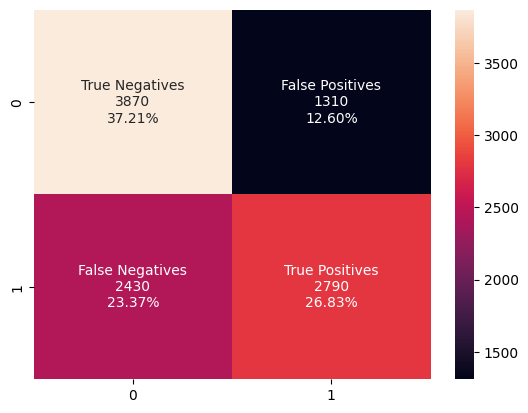

In [359]:
cf_matrix = confusion_matrix(y_test, y_pred_test)

group_names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
group_counts = [f'{value}' for value in cf_matrix.flatten()]
group_percentages = [f'{value:.2%}' for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
_ = sns.heatmap(cf_matrix, annot=labels, fmt='')

Видим, что даже такая продвинутая модель как `LGBMClassifier`, к сожалению, имеет значительные трудности и допускает ошибки.

Рассмотим их классы подробнее:

- <b>ошибок II-рода - "_False Negatives_" довольно много, почти `23.37%`</b> Это очень высокие цифры, ведь минимизация именно этого типа ошибки так важна для нашей задачи. В идеале нам бы хотелось, чтобы ситуаций, когда модель не выдавала предупреждения в случаях, когда ей это определённо следовало бы сделать, было минимальное количество. Жаль, но сейчас это не так.

- <b>ошибок I-рода - "_False Positives_" значительно меньше, около `12.60%`, но они для нас не так критичны</b>. Выдать предупреждение о возможном риске ДТП для безопасной поездки не так существенно, в конце концов это демонстрирует заботу каршеринговой компании о здоровье и благополучии своих клиентов.

#### Шаг 6.3 Выведите полноту и точность на график.

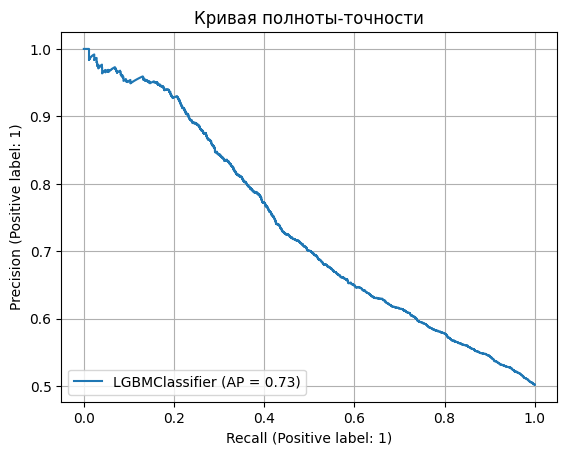

In [360]:
display = PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test, name=best_model.__class__.__name__)
_ = display.ax_.set_title('Кривая полноты-точности')
_ = display.ax_.grid(True)

График полноты-точности также подтверждает довольно скромные качественные показатели сконструированной в итоге модели.

#### Шаг 6.4 Проанализируйте важность основных факторов, влияющих на вероятность ДТП.

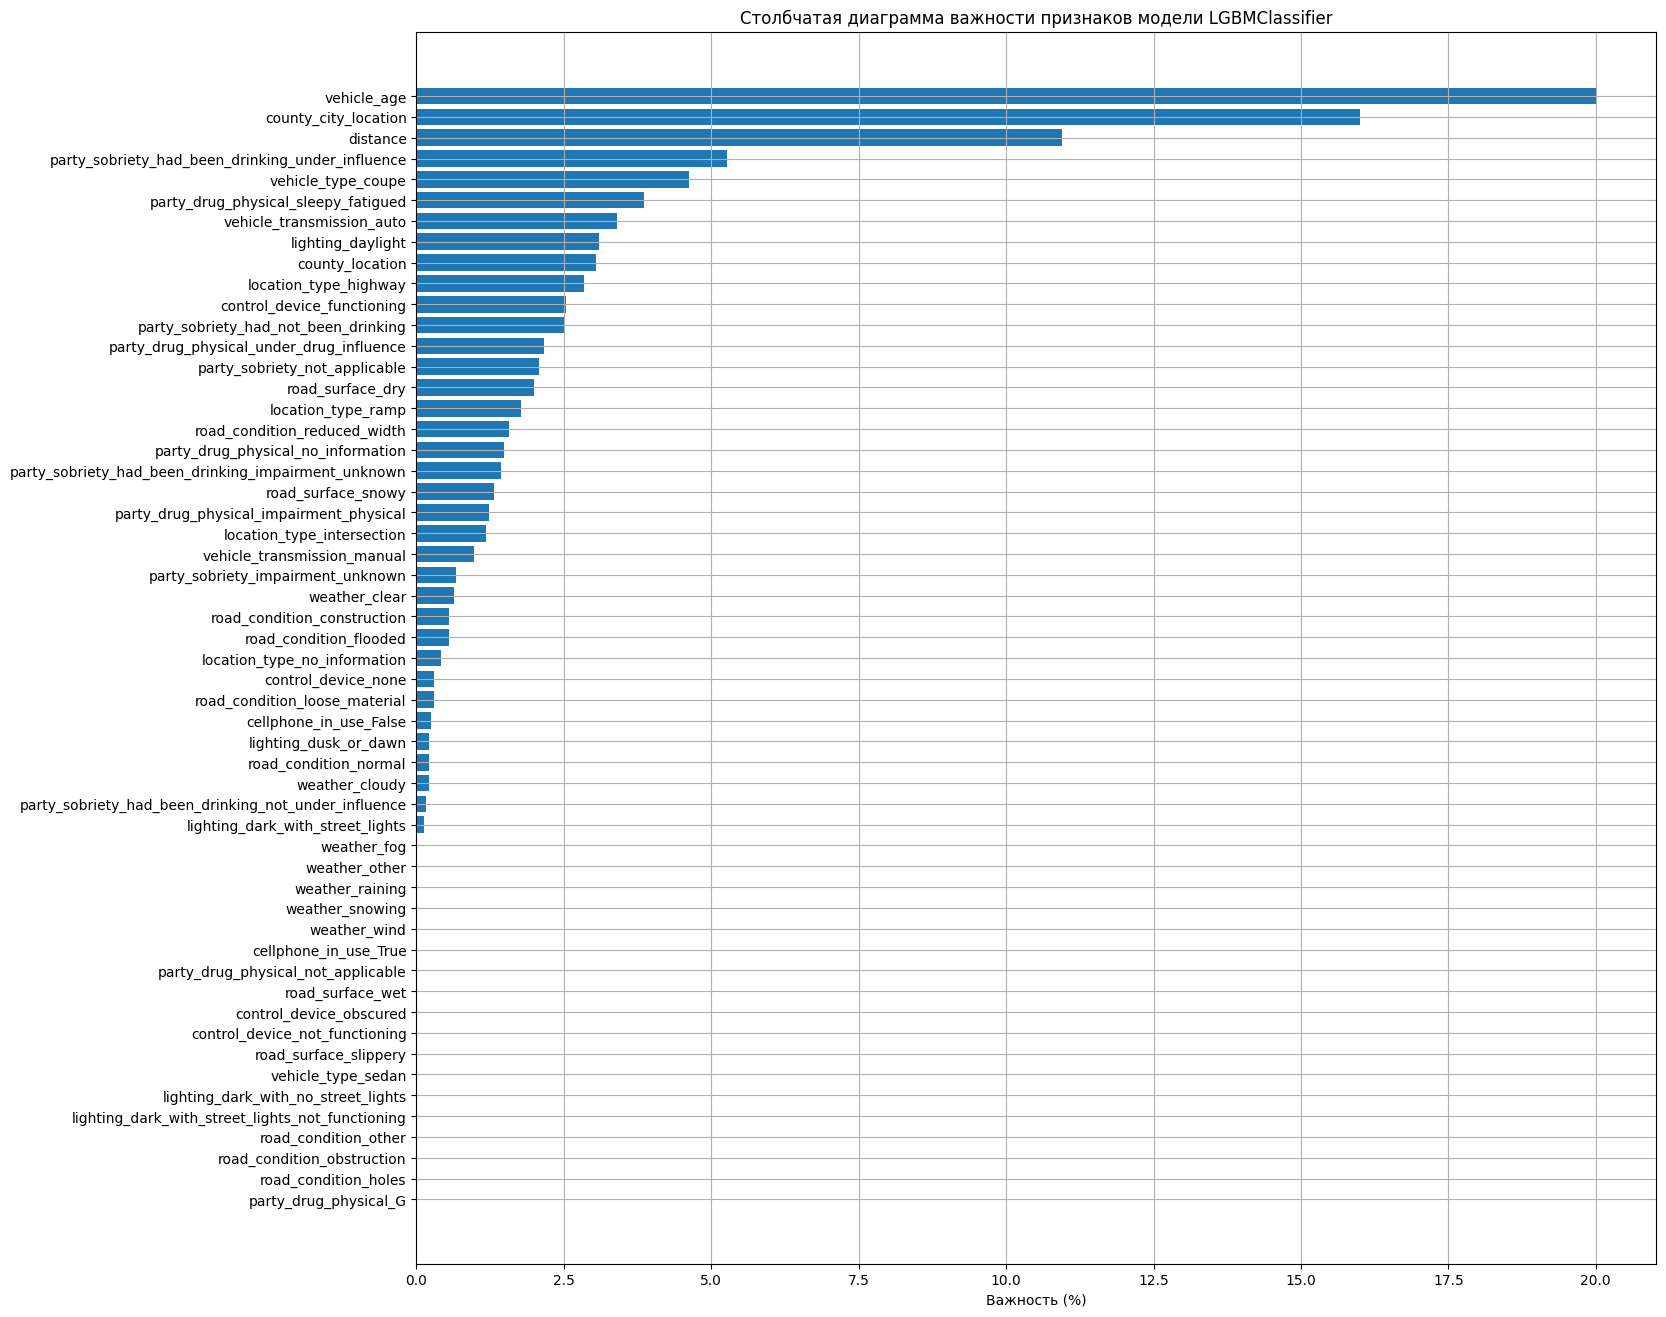

In [361]:
def plot_boosting_feature_importances(model, feature_names):
    feature_importances = (model.feature_importances_ / sum(model.feature_importances_)) * 100.
    results = pd.DataFrame({'Features': feature_names, 'Importances': feature_importances})
    results.sort_values(by='Importances', inplace=True)

    fig, ax = plt.subplots(figsize=(16, 16))
    _ = ax.barh(results['Features'], results['Importances'])
    _ = ax.set_title(f'Столбчатая диаграмма важности признаков модели {model.__class__.__name__}')
    _ = ax.set_xlabel('Важность (%)')
    _ = ax.grid(True)
    
plot_boosting_feature_importances(tuned_lgbm, X_train.columns.values)

#### Шаг 6.5 Для одного из выявленных важных факторов покажите график зависимости фактора и целевой переменной.

Пример решения задачи 3:

Выявили, что самый важный фактор ДТП — уровень трезвости виновника party_sobriety. Из таблицы исходных данных известно: есть несколько уровней трезвости. Тогда решение по пунктам выглядит так:

- Для графического анализа будем использовать столбчатую диаграмму. В ней отразим зависимость числа ДТП от уровня трезвости. Проанализируем график, сделаем выводы.
- Предложить оборудовать автомобиль анализатором алкогольного опьянения. Измерение состояния при посадке сделать обязательным условием допуска за руль. А чтобы убедиться, что в трубку дышит именно водитель, добавить камеру, направленную на водительское место.

В качестве такого фактора возьмём фактор `county_location`:

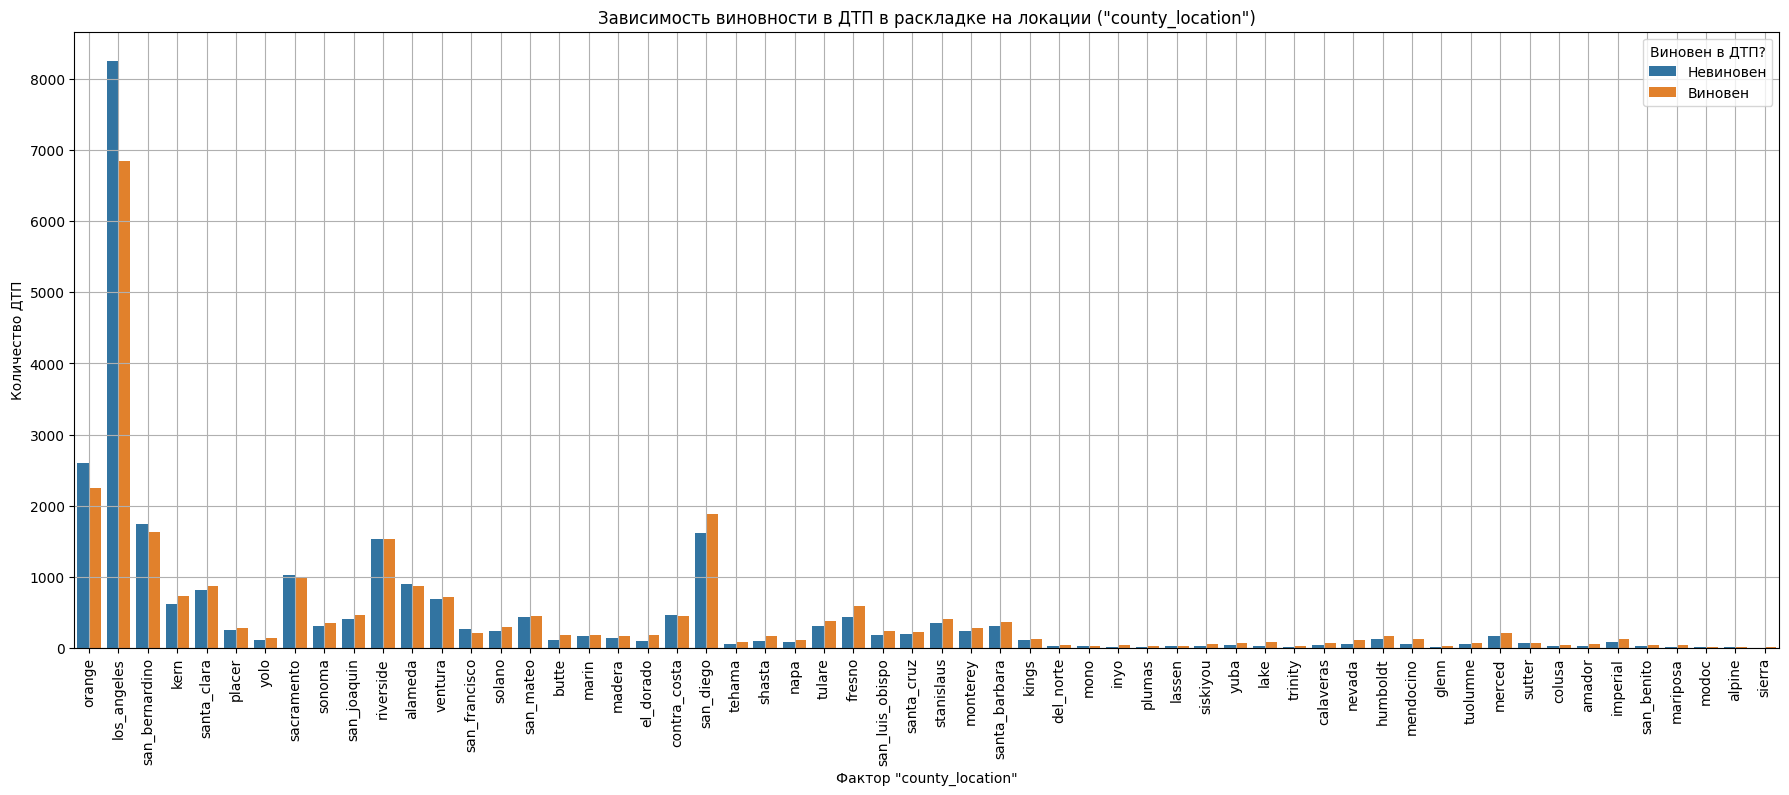

In [362]:
fig, ax = plt.subplots(figsize=(22, 8))
sns.countplot(data=sql_df, x='county_location', hue='at_fault', ax=ax)
_ = ax.set_xlabel(f'Фактор "county_location"')
_ = ax.set_ylabel('Количество ДТП')
_ = ax.set_title('Зависимость виновности в ДТП в раскладке на локации ("county_location")')
_ = ax.legend(title='Виновен в ДТП?', loc='upper right', labels=['Невиновен', 'Виновен'])
_ = ax.tick_params(axis='x', rotation=90)
_ = ax.grid(True)

Диаграмма показывает, что фактор `county_location` является довольно скромным по своей предсказательной способности для обученной модели. Почти во всех локациях столбики примерно одной высоты, т.е. количество виновных и количество невиновных примерно равны между собой, либо не очень сильно отличаются. Исключением может быть разве что _Лос-Анжелес_, но и для данной локации разница между количеством виновных и невиновных не так велико.

Напрашивается вывод о том, что <b>одного только знания локации не достаточно для того, чтобы судить о том, будет ли какой-то конкретный водитель виноват в ДТП</b>.

#### Шаг 6.6 Для одного из выявленных важных факторов предложите, чем можно оборудовать автомобиль, чтобы учесть этот фактор во время посадки водителя.

Для таких факторов как `vehicle_age` (1 место), `vehicle_type` (5 место) и `vehicle_transmission` (7 место) можно было предоставлять в модель эти данные об автомобиле, впрочем, скорее всего это делается и так, ведь никакого дополнительного оборудования это не требует. Все эти данные необходимо передавать в модель как только клиент каршеринга определился с маршрутом, сев за руль конкретного авто.

Какое дополнительное оборудование можно было бы установить в автомобиль для улучшения создаваемой системы прогнозирования будет сказано ниже - данное оборудование не относится к выявленным факторам, а скорее может говорить о появлении новых факторов в результате установки такого оборудования.

# Шаг 7. Сделайте общий вывод по модели

#### Шаг 7.1 Кратко опишите лучшую модель.

Для решения данной задачи была выбрана и обучена модель градиентного бустинга для классификации - `LGBMClassifier`. Гиперпараметры модели были подобраны случайным поиском с использованием 10-порционного (_fold_-ового) разбиения тренировочной выборки на 300 итерациях.

Выбранными гиперпараметрами стали:

- `learning_rate=0.03`;

- `max_depth=2`;

- `n_estimators=800`;

- `num_leaves=75`

#### Шаг 7.2 Сделайте вывод: насколько возможно создание адекватной системы оценки риска при выдаче авто?

В ходе работы была создана модель для оценки риска ДТП по выбранному маршруту движения.

Качество созданной модели я бы оценил как очень скромное. Говоря о причинах такого качества, на мой взгляд, есть связь с тем, что модель всё же была построена на основе данных, несколько косвенно отосящихся непосредственно к задаче. Имеющиеся данные представляют собой сведения об уже случившихся ДТП: информация об автомобиле, водителе, месте ДТП.

При этом довольно много т.н. _исходной_ информации не было предоставлено, как об автомобиле, так и о водителе. Более подробно о том, что это могла бы быть за информация, написано ниже.

На мой взгляд, создание адекватной системы оценки риска при выдаче авто всё же возможно, но для этого требуется дополнительная входная информация.

#### Шаг 7.3 Какие факторы ещё необходимо собирать, чтобы улучшить модель?

Говоря о дополнительных факторах, которые могли бы помочь добиться более высокого качества, я бы выделил следующие:

- факторы, связанные с <u>автомобилем</u> (вся информация понимается под временем "_в момент аренды авто_"):

    - давление в шинах;
    - количество бензина;
    - количество омывающей жидкости;
    - горит ли лампочка "_Check Engine_";
    - температура двигателя.

<br>

- факторы, связанные с <u>водителем</u>:

    - водительский стаж;
    - дата последней поездки за рулём;
    - история правонарушений, связанных с нарушением ПДД;
    - пульс (несколько замеров);
    - кровяное давление;
    - количество часов сна предыдущей ночью;
    - уровень стресса (через умные часы/браслет).